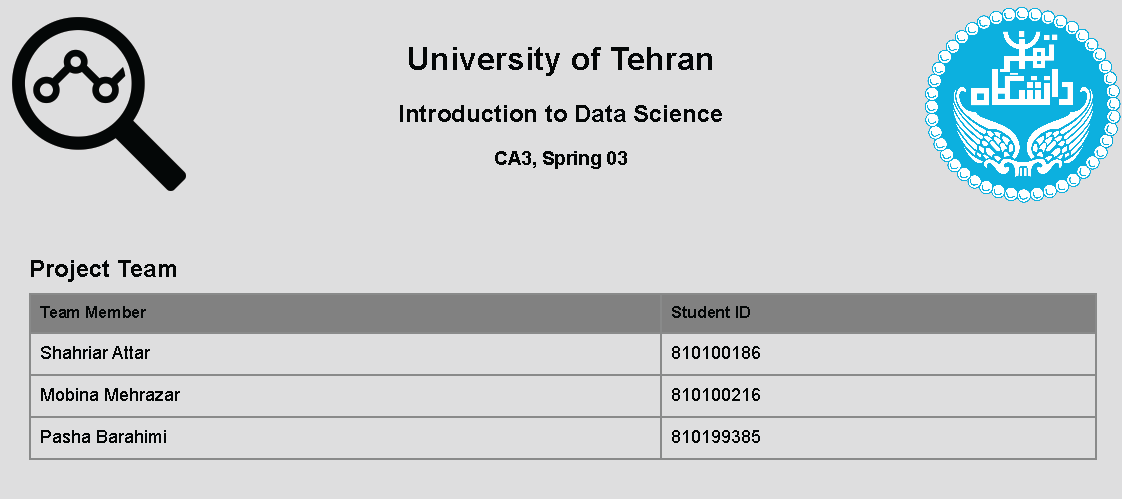


# Spotify Dataset Analysis

## Table of Contents

-   [Spotify Dataset Analysis](#spotify-dataset-analysis)
    -   [Introduction](#introduction)
    -   [Objectives](#objectives)
    -   [Tasks](#tasks)
    -   [Environment Setup](#environment-setup)
    -   [Warm-Up](#warm-up)
    -   [Main Task (Spotify Dataset Analysis)](#main-task-spotify-dataset-analysis)
    -   [Questions](#questions)
    -   [Resources](#resources)

## Introduction

In this assignment, we are going to work with [PySpark](https://spark.apache.org/docs/latest/api/python/index.html), which is the Python API for Apache Spark. It enables us to perform real-time, large-scale data processing in a distributed environment using Python.

## Objectives

The purpose of this assignment is as follows:

1. Learning how to set up PySpark and its requirements.
2. Doing some warm-up exercises, in order to learn how to use PySpark.
3. Using this knowledge to do some investigation on a dataset.

## Tasks

1. **Warm-Up**: In this task, we will do some warm-up exercises to get familiar with PySpark.
2. **Spotify Dataset Analysis**: In this task, we will analyze a dataset containing information about songs and artists from Spotify.


## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.


In [1]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler, VectorAssembler

In [2]:
STOCKS = "../data/stocks.csv"
SPOTIFY = "../data/spotify.parquet"

## Warm-Up

The provided dataset (stocks.csv) contains information about a stock market, with opening, closing, the highest and the lowest price with its volume for each day.


In [3]:
spark: SparkSession = SparkSession.builder.master("local").appName("warm_up").getOrCreate()

In [4]:
def show_df(df: DataFrame, truncate: bool = True) -> None:
    df.show(n=10, truncate=truncate)
    print(f"Total number of rows: {df.count()}")
    df.printSchema()

1. First, we will read the CSV file.


In [5]:
df: DataFrame = spark.read.csv(STOCKS, header=True, inferSchema=True)

2. Let's find out about the schema of data


In [6]:
df

DataFrame[Date: date, Open: double, High: double, Low: double, Close: double, Volume: int, Adj Close: double]

In [7]:
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|212.79999700000002|        213.000002|      

As we can see, the dataset contains the following columns:

-   `Date`: The date of the record.
-   `Open`: The opening price of the stock on that day.
-   `High`: The highest price of the stock on that day.
-   `Low`: The lowest price of the stock on that day.
-   `Close`: The closing price of the stock on that day.
-   `Volume`: The number of stocks traded that day.
-   `Adj Close`: The adjusted closing price of the stock on that day.

The `Adj Close` column is the adjusted closing price of the stock on that day. It is adjusted for stock splits, dividends, and other corporate actions that may have occurred after the date of the record.


In [8]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|summary|              Open|              High|               Low|            Close|             Volume|         Adj Close|
+-------+------------------+------------------+------------------+-----------------+-------------------+------------------+
|  count|              1762|              1762|              1762|             1762|               1762|              1762|
|   mean| 313.0763111589103| 315.9112880164581| 309.8282405079457|312.9270656379113|9.422577587968218E7| 75.00174115607275|
| stddev|185.29946803981522|186.89817686485767|183.38391664371008|185.1471036170943|6.020518776592709E7| 28.57492972179906|
|    min|              90.0|         90.699997|         89.470001|        90.279999|           11475900|         24.881912|
|    max|        702.409988|        705.070023|        699.569977|       702.100021|          470249500|127.96609099999999|
+-------

3. Now, we will select the open, close, and volume of the rows with closing price less than 500.


In [9]:
selected_df = df.filter(df["close"] < 500).select("open", "close", "volume")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



Let's do that using SQL.


In [10]:
df.createOrReplaceTempView("stocks")  # create a temporary view to use SQL queries


In [11]:
selected_df = spark.sql("SELECT open, close, volume FROM stocks WHERE close < 500")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



We can also do that using library functions.


In [12]:
selected_df = F.col("close") < 500
selected_df = df.filter(selected_df).select("open", "close", "volume")
show_df(selected_df)

+------------------+------------------+---------+
|              open|             close|   volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
+------------------+------------------+---------+
only showing top 10 rows

Total number of rows: 1359
root
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)



4. Then, we'll find those records with opening price more than 200 and closing price less than 200.


In [13]:
selected_df = (F.col("open") > 200) & (F.col("close") < 200)
selected_df = df.filter(selected_df)
show_df(selected_df)

+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+

Total number of rows: 3
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



5. Now, let's extract the year from the date column and save it in a new column named `Year`.


In [14]:
df = df.withColumn("Year", F.year("date"))
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
|2010-01-11|212.

6. For each year, let's find the minimum volume and show it in a column named `MinVolume`.


In [15]:
min_volume = df.groupBy("Year").agg(F.min("volume").alias("MinVolume"))
show_df(min_volume)

+----+---------+
|Year|MinVolume|
+----+---------+
|2015| 13046400|
|2013| 41888700|
|2014| 14479600|
|2012| 43938300|
|2016| 11475900|
|2010| 39373600|
|2011| 44915500|
+----+---------+

Total number of rows: 7
root
 |-- Year: integer (nullable = true)
 |-- MinVolume: integer (nullable = true)



7. For each year and month, we'll show the highest low price as `MaxLow`.


In [16]:
df = df.withColumn("Month", F.month("date"))
show_df(df)

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|Month|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+-----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|    1|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|    1|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|    1|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|    1|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700

In [17]:
max_low = df.groupBy("Year", "Month").agg(F.max("low").alias("MaxLow"))
show_df(max_low)

+----+-----+------------------+
|Year|Month|            MaxLow|
+----+-----+------------------+
|2012|   10|        665.550026|
|2010|    7|        260.300003|
|2010|   12|        325.099991|
|2015|    2|        131.169998|
|2014|    4|        589.799988|
|2015|   12|        117.809998|
|2016|    7|            103.68|
|2016|   11|        111.400002|
|2012|    8| 673.5400089999999|
|2013|    2|473.24997699999994|
+----+-----+------------------+
only showing top 10 rows

Total number of rows: 84
root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- MaxLow: double (nullable = true)



8. In the last step, let's calculate mean and standard derivation of high price over the whole data frame and show them in two decimal places.


In [18]:
df_stats = df.select(F.format_number(F.mean("high"), 2).alias("MeanHigh"), F.format_number(F.stddev("high"), 2).alias("StdHigh"))
show_df(df_stats)


+--------+-------+
|MeanHigh|StdHigh|
+--------+-------+
|  315.91| 186.90|
+--------+-------+

Total number of rows: 1
root
 |-- MeanHigh: string (nullable = true)
 |-- StdHigh: string (nullable = true)



## Main Task (Spotify Dataset Analysis)

Now that we've learnt the basics of PySpark, let’s do some investigation on a real dataset! The provided dataset (spotify.parquet) contains information about songs streamed on Spotify, which is an audio streaming and media service provider. We have access to a song’s album, artist, its musical characteristics and its release date.


In [19]:
spark = SparkSession.builder.master("local").appName("spotify").config("spark.executor.memory", "2g").getOrCreate()

In [20]:
df : DataFrame = spark.read.parquet(SPOTIFY)
show_df(df, truncate=False)

+----------------------+----------------------+-------------------------+----------------------+----------------------------+--------------------------+------------+-----------+--------+------------------+------+---+-------------------+----+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+
|id                    |name                  |album                    |album_id              |artists                     |artist_ids                |track_number|disc_number|explicit|danceability      |energy|key|loudness           |mode|speechiness|acousticness     |instrumentalness    |liveness|valence           |tempo             |duration_ms|time_signature|year|release_date|
+----------------------+----------------------+-------------------------+----------------------+----------------------------+--------------------------+------------+-----------+--------+------------------+------+---+--------------

The dataset contains the follwowing columns:

-   **id**: A unique identifier for each track.
-   **name**: The name of the track.
-   **album**: The album to which the track belongs.
-   **album_id**: A unique identifier for the album.
-   **artists**: The artist or artists who performed the track.
-   **artist_ids**: Unique identifiers for the artist or artists.
-   **track_number**: The track's position on the album.
-   **disc_number**: The number of the disc on which the track appears (useful for multi-disc albums).
-   **explicit**: A boolean value indicating whether the track has explicit lyrics.
-   **danceability**: A measure of how suitable the track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity.
-   **energy**: A measure of intensity and activity, typically higher for faster, louder, more energetic tracks.
-   **key**: The key of the track (e.g., C, C#, D, etc. which is represented numerically from 0 to 11).
-   **loudness**: The overall loudness of the track.
-   **mode**: The modality of the track (major or minor).
-   **speechiness**: A measure of the presence of spoken words in the track.
-   **acousticness**: A measure of whether the track is acoustic.
-   **instrumentalness**: A measure of the likelihood the track is instrumental.
-   **liveness**: A measure of the presence of an audience in the recording of the track.
-   **valence**: A measure of musical positiveness conveyed by a track.
-   **tempo**: The overall estimated tempo of the track in beats per minute.
-   **duration_ms**: The duration of the track in milliseconds.
-   **time_signature**: An estimated overall time signature of a track.
-   **year**: The year the track was released.
-   **release_date**: The exact date when the track was released.


In order to use the `relaeae_date`, we need to convert it to a date format.


In [21]:
df = df.withColumn("release_date", F.to_date(df["release_date"]))
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: date (nullable = true)



Let's check if the dataset contains null values.


In [22]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|  0|   3|   11|       0|      0|         0|           0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|   0|           0|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

We'll drop these rows.


In [23]:
df = df.dropna()

Also, we need to check if there exist any duplicate rows in the dataset.


In [24]:
df.groupBy("id").count().where("count > 1").show()

+---+-----+
| id|count|
+---+-----+
+---+-----+



We can see that there are no duplicate rows in the dataset.


Now, let's change the `mode` column to a boolean column, where 1 represents major and 0 represents minor.


In [25]:
df = df.withColumn("mode", F.col("mode").cast("boolean"))
df = df.withColumnRenamed("mode", "is_major")
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+-

We can use the duration_min more than duration_ms, so let's create a new column named `duration_min`.


In [26]:
df = df.withColumn("duration_min", F.round(F.col("duration_ms") / 60000, 2))
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+--------------

Let's check if we have any song which is released before 1900.


In [27]:
df.filter(F.col("year") < 1900).show()

+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+--------+-----------+------------------+------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+
|                  id|             name|     album|            album_id|    artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|is_major|speechiness|      acousticness|  instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|
+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+--------+-----------+------------------+------------------+--------

We can see that these 10 songs have a wrong release date. They are all from a single album named 'Optimism 2' by 'iCizzle'. Based on [Spotify link](https://open.spotify.com/album/211vSdhxt58A943r9QWRKo), this album is released at September 4, 2018. Let's fix the release date of these songs.


In [28]:
df = df.withColumn("release_date", F.when(F.col("album") == "Optimism 2", "2018-09-04").otherwise(F.col("release_date")))
df = df.withColumn("year", F.when(F.col("album") == "Optimism 2", 2018).otherwise(F.col("year")))

df.filter(F.col("album") == "Optimism 2").show()

+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+--------+-----------+------------------+------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+
|                  id|             name|     album|            album_id|    artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|is_major|speechiness|      acousticness|  instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|
+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+--------+-----------+------------------+------------------+--------

Then, we'll calculate the age of the songs.


In [29]:
df = df.withColumn("song_age", F.lit(2024) - F.col("year"))
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+--------

Then, we'll scale the `loudness`.


In [30]:
assembler = VectorAssembler(inputCols=["loudness"], outputCol="loudness_vec")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="loudness_vec", outputCol="loudness_scaled", withStd=True, withMean=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+----

Let's calculate the loudness-energy difference for each song and save it in a new column named `loudness_energy_diff`.


In [31]:
df = df.withColumn("loudness_energy_diff", df["loudness"] - df["energy"])
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+--------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|loudness_energy_diff|
+--------------------+--------------------+--------------------+--------------------+-----------------

We can also calculate `dance_valence_interaction` by multiplying `danceability` and `valence` columns.


In [32]:
df = df.withColumn("dance_valence_interaction", df["danceability"] * df["valence"])
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+--------------------+-------------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|loudness_energy_diff|dance_valence_interaction|
+--------------------+--------------------+-------

Let's also calculate the release_date's day of the week and save it in a new column named `day_of_week`.


In [33]:
df = df.withColumn("day_of_week", F.date_format("release_date", "EEEE"))
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+--------------------+-------------------------+-----------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|loudness_energy_diff|dance_valence_interaction|day_of_week|
+--------------------+----

We may have many outliers in the dataset. But let's remove some of them based on the `duration_min` column.


Songs more than 15 minutes are considered outliers as they are more likely to be podcasts or audio-books. Also, songs less than 30 seconds are considered outliers as they are more likely to be ads or short announcements. Let's remove these outliers.


In [34]:
count_more_than_15_minutes = df.filter(F.col("duration_min") > 15).count()
count_less_than_30_seconds = df.filter(F.col("duration_min") < 0.5).count()
print(f"More than 15 minutes: {count_more_than_15_minutes}")
print(f"Less than 30 seconds: {count_less_than_30_seconds}")

More than 15 minutes: 7984
Less than 30 seconds: 7534


In [35]:
df = df.filter((F.col("duration_min") > 0.5) & (F.col("duration_min") < 15))
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+--------------------+-------------------------+-----------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|loudness_energy_diff|dance_valence_interaction|day_of_week|
+--------------------+----

We can also have a new data frame for yearly statistics.


Let's first calculate the average `danceability`, `energy`, `loudness`, `speechiness`, `valence` and `duration_min` and the mode of `day_of_week` for each year.


In [36]:
year_stats = df.groupBy("year").agg(
    F.avg("danceability").alias("avg_danceability"),
    F.avg("energy").alias("avg_energy"),
    F.avg("loudness").alias("avg_loudness"),
    F.avg("speechiness").alias("avg_speechiness"),
    F.avg("acousticness").alias("avg_acousticness"),
    F.avg("instrumentalness").alias("avg_instrumentalness"),
    F.avg("liveness").alias("avg_liveness"),
    F.avg("tempo").alias("avg_tempo"),
    F.avg("valence").alias("avg_valence"),
    F.avg("duration_min").alias("avg_duration_min"),
    F.mode("day_of_week").alias("mode_day_of_week"),
    F.count("id").alias("count")
).orderBy("year")

show_df(year_stats)

+----+------------------+-------------------+-------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+----------------+-----+
|year|  avg_danceability|         avg_energy|       avg_loudness|     avg_speechiness|  avg_acousticness|avg_instrumentalness|       avg_liveness|         avg_tempo|        avg_valence|  avg_duration_min|mode_day_of_week|count|
+----+------------------+-------------------+-------------------+--------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+----------------+-----+
|1900|0.4838571428571428|0.28219285714285713|-18.077785714285717|0.051692857142857145|0.7130714285714285|  0.7369285714285715| 0.1292642857142857|128.72857142857143|0.42215714285714284| 8.334285714285715|          Monday|   14|
|1908|0.6041052631578946|0.47369473684210534|-15.401263157894741| 0.07639473684210525|0.

Let's also use exploding function to split the artists column into multiple rows.


In [37]:
df = df.withColumn("artists", F.split(F.regexp_extract(F.col("artists"), r"\[(.*)\]", 1), ", "))
df = df.withColumn("artist_ids", F.split(F.regexp_extract(F.col("artist_ids"), r"\[(.*)\]", 1), ", "))
show_df(df)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+--------------------+--------------------+--------------------+-------------------------+-----------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|is_major|speechiness|     acousticness|    instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|duration_min|song_age|        loudness_vec|     loudness_scaled|loudness_energy_diff|dance_valence_interaction|day_of_week|
+--------------------+----

Let's remove the rows which the size of artists and artist_ids are not equal.


In [38]:
df.filter(F.size(F.col("artists")) != F.size(F.col("artist_ids"))).count()

7736

In [39]:
df_exploded = df.filter(F.size(F.col("artists")) == F.size(F.col("artist_ids")))

In [40]:
df_exploded = df_exploded.withColumn("artist_and_id", F.arrays_zip("artists", "artist_ids"))
df_exploded = df_exploded.withColumn("artist_and_id", F.explode("artist_and_id"))

df_exploded = df_exploded.withColumn("artist", df_exploded["artist_and_id"].artists)
df_exploded = df_exploded.withColumn("artist_id", df_exploded["artist_and_id"].artist_ids)

df_exploded = df_exploded.drop("artists", "artist_ids", "artist_and_id")

df_exploded = df_exploded.withColumn("artist", F.trim(df_exploded["artist"]))
df_exploded = df_exploded.withColumn("artist_id", F.trim(df_exploded["artist_id"]))

df_exploded = df_exploded.withColumn("artist", F.regexp_replace("artist", r"^'|'$", ""))
df_exploded = df_exploded.withColumn("artist_id", F.regexp_replace("artist_id", r"^'|'$", ""))

show_df(df_exploded, truncate=False)


+----------------------+----------------------+-------------------------+----------------------+------------+-----------+--------+------------------+------+---+-------------------+--------+-----------+-----------------+--------------------+--------+------------------+------------------+-----------+--------------+----+------------+------------+--------+---------------------+--------------------+--------------------+-------------------------+-----------+------------------------+----------------------+
|id                    |name                  |album                    |album_id              |track_number|disc_number|explicit|danceability      |energy|key|loudness           |is_major|speechiness|acousticness     |instrumentalness    |liveness|valence           |tempo             |duration_ms|time_signature|year|release_date|duration_min|song_age|loudness_vec         |loudness_scaled     |loudness_energy_diff|dance_valence_interaction|day_of_week|artist                  |artist_id     

In [41]:
count = df.count()
exploded_count = df_exploded.count()

print("Number of Rows (Before Exploding):", count)
print("Number of Rows (After Exploding):", exploded_count)
print(f"Songs have {exploded_count / count:.2f} artists on average")

Number of Rows (Before Exploding): 1188042
Number of Rows (After Exploding): 1743616
Songs have 1.47 artists on average


Let's plot a heatmap to show the correlation between the features.


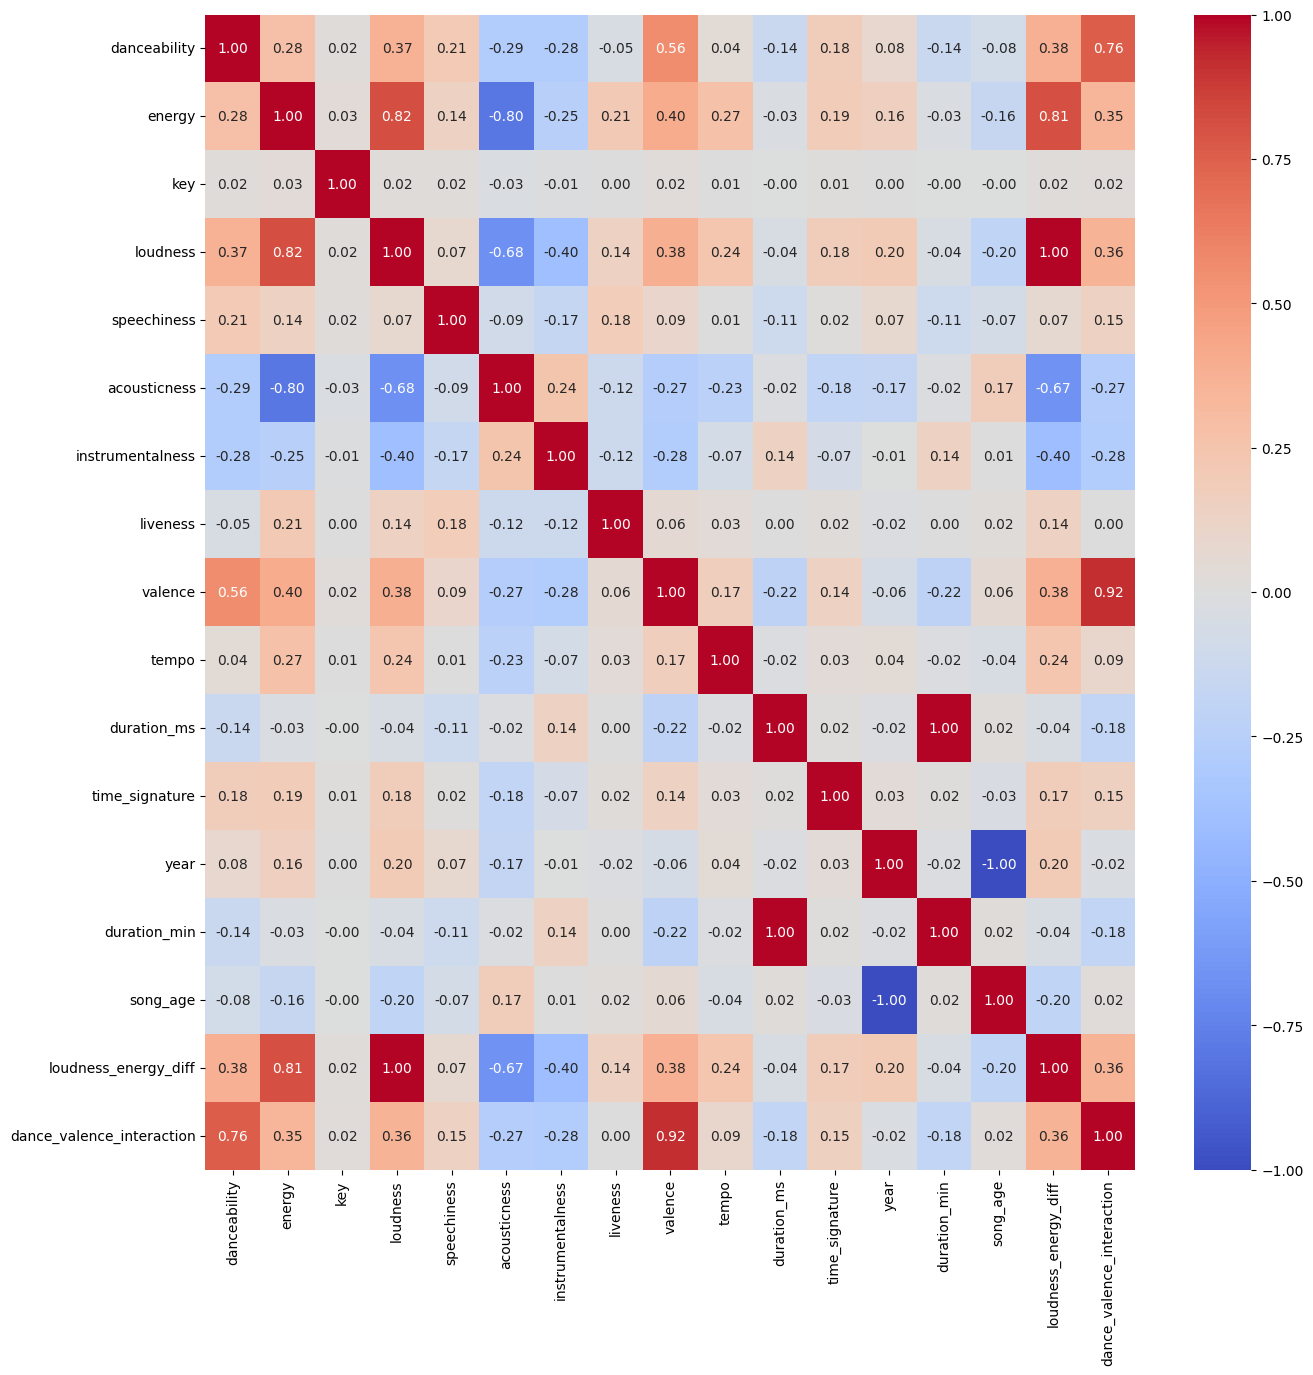

In [42]:
numeric_features = [col for col, dtype in df.dtypes if dtype in ("int", "double", "bigint")]
numeric_features.remove("track_number")
numeric_features.remove("disc_number")
numeric_data = df.select(numeric_features)

correlation_matrix = np.corrcoef(np.array(numeric_data.collect()).T)

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, xticklabels=numeric_features, yticklabels=numeric_features, fmt=".2f", cmap="coolwarm")
plt.show()

We can see the correlation between features in the above plot. Let's also focus on highly correlated features.


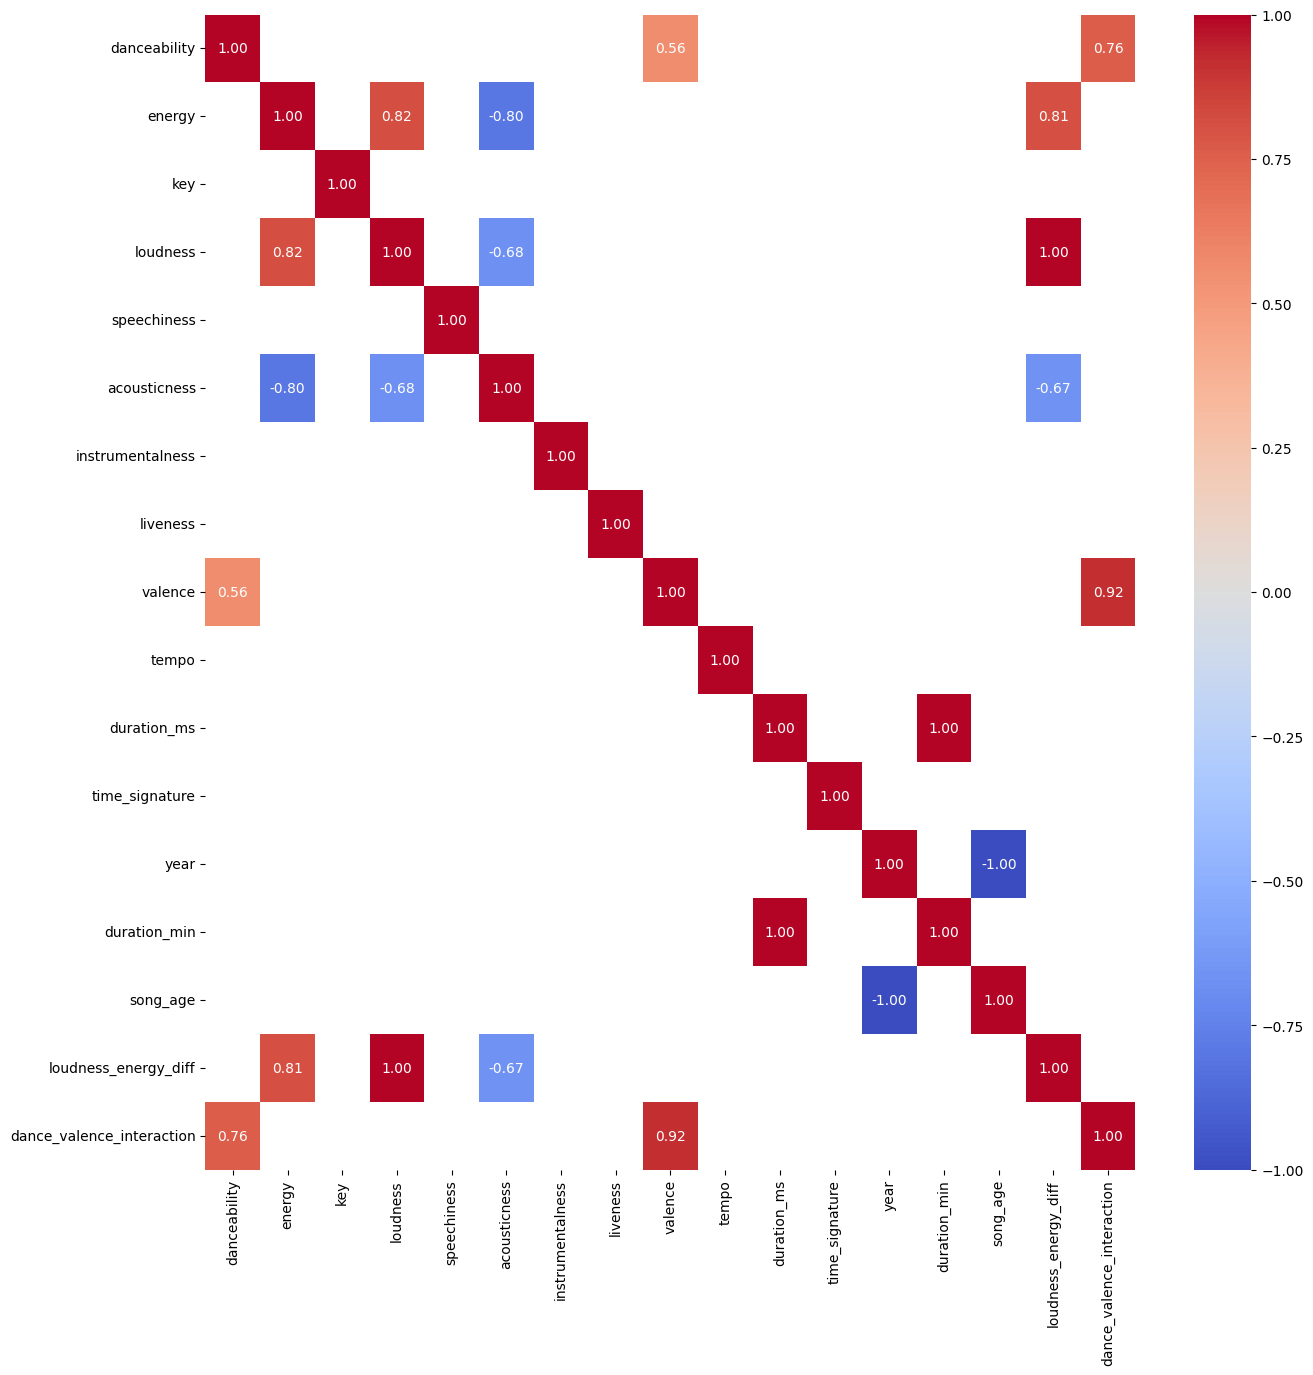

In [43]:
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, xticklabels=numeric_features, yticklabels=numeric_features, fmt=".2f", cmap="coolwarm", mask=(np.abs(correlation_matrix) < 0.5))
plt.show()

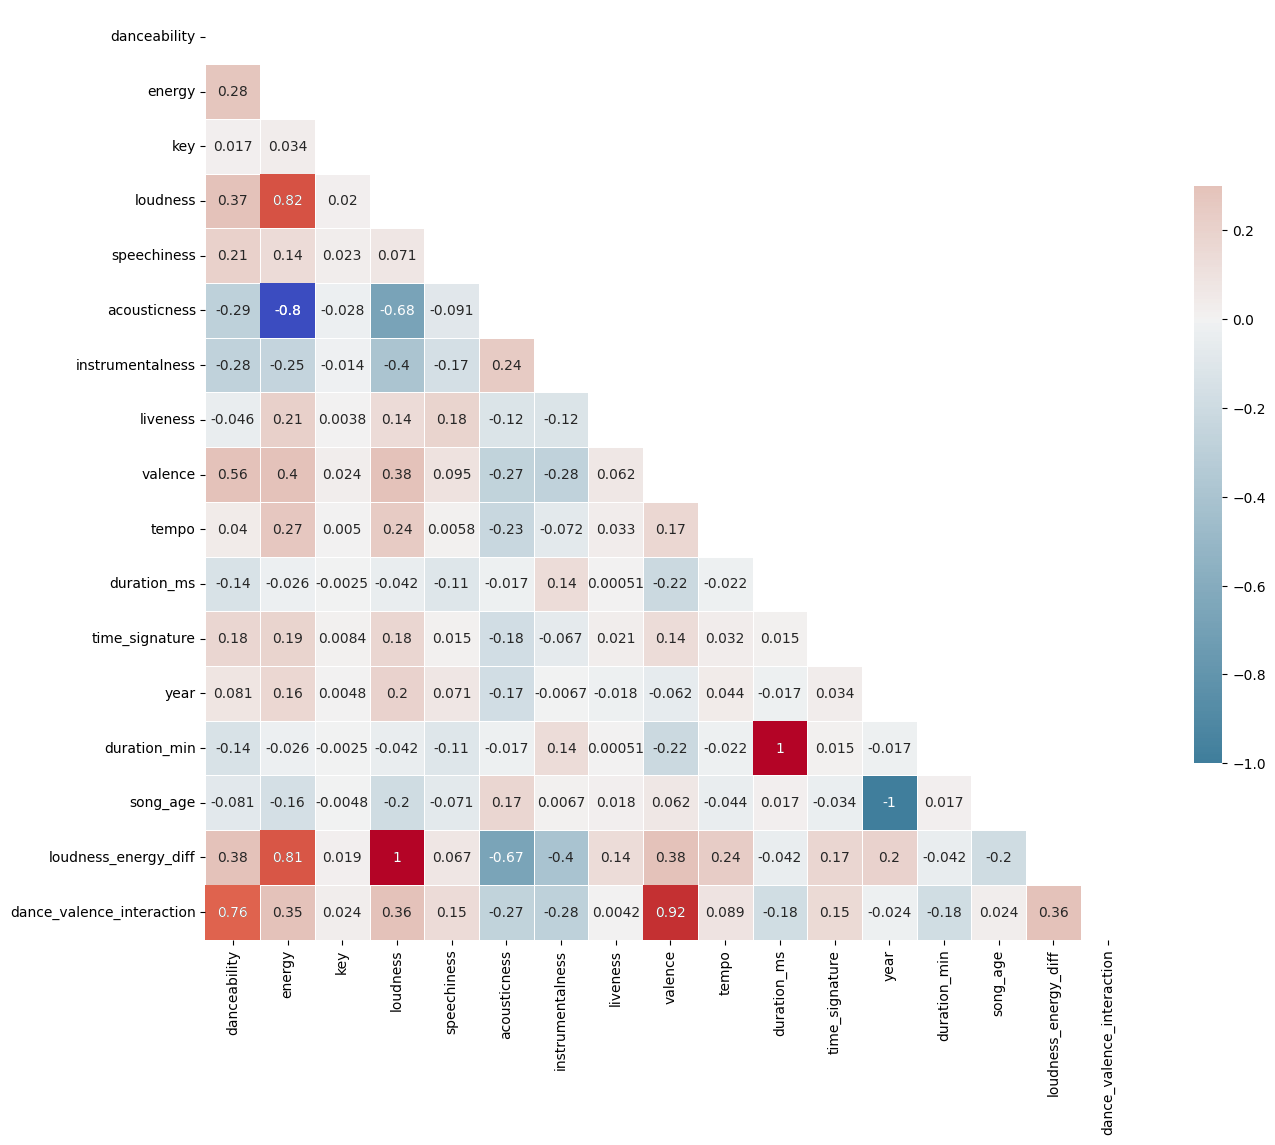

In [44]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,
)

threshold = 0.7
significant = (np.abs(correlation_matrix) >= threshold) & (np.abs(correlation_matrix) < 1)
sns.heatmap(
    correlation_matrix,
    mask=~significant | mask,
    cmap="coolwarm",
    cbar=False,
    annot=True,
    ax=ax,
    xticklabels=numeric_features,
    yticklabels=numeric_features,
)

plt.show()

We can also create a pair-plot to show the relationship between the features.


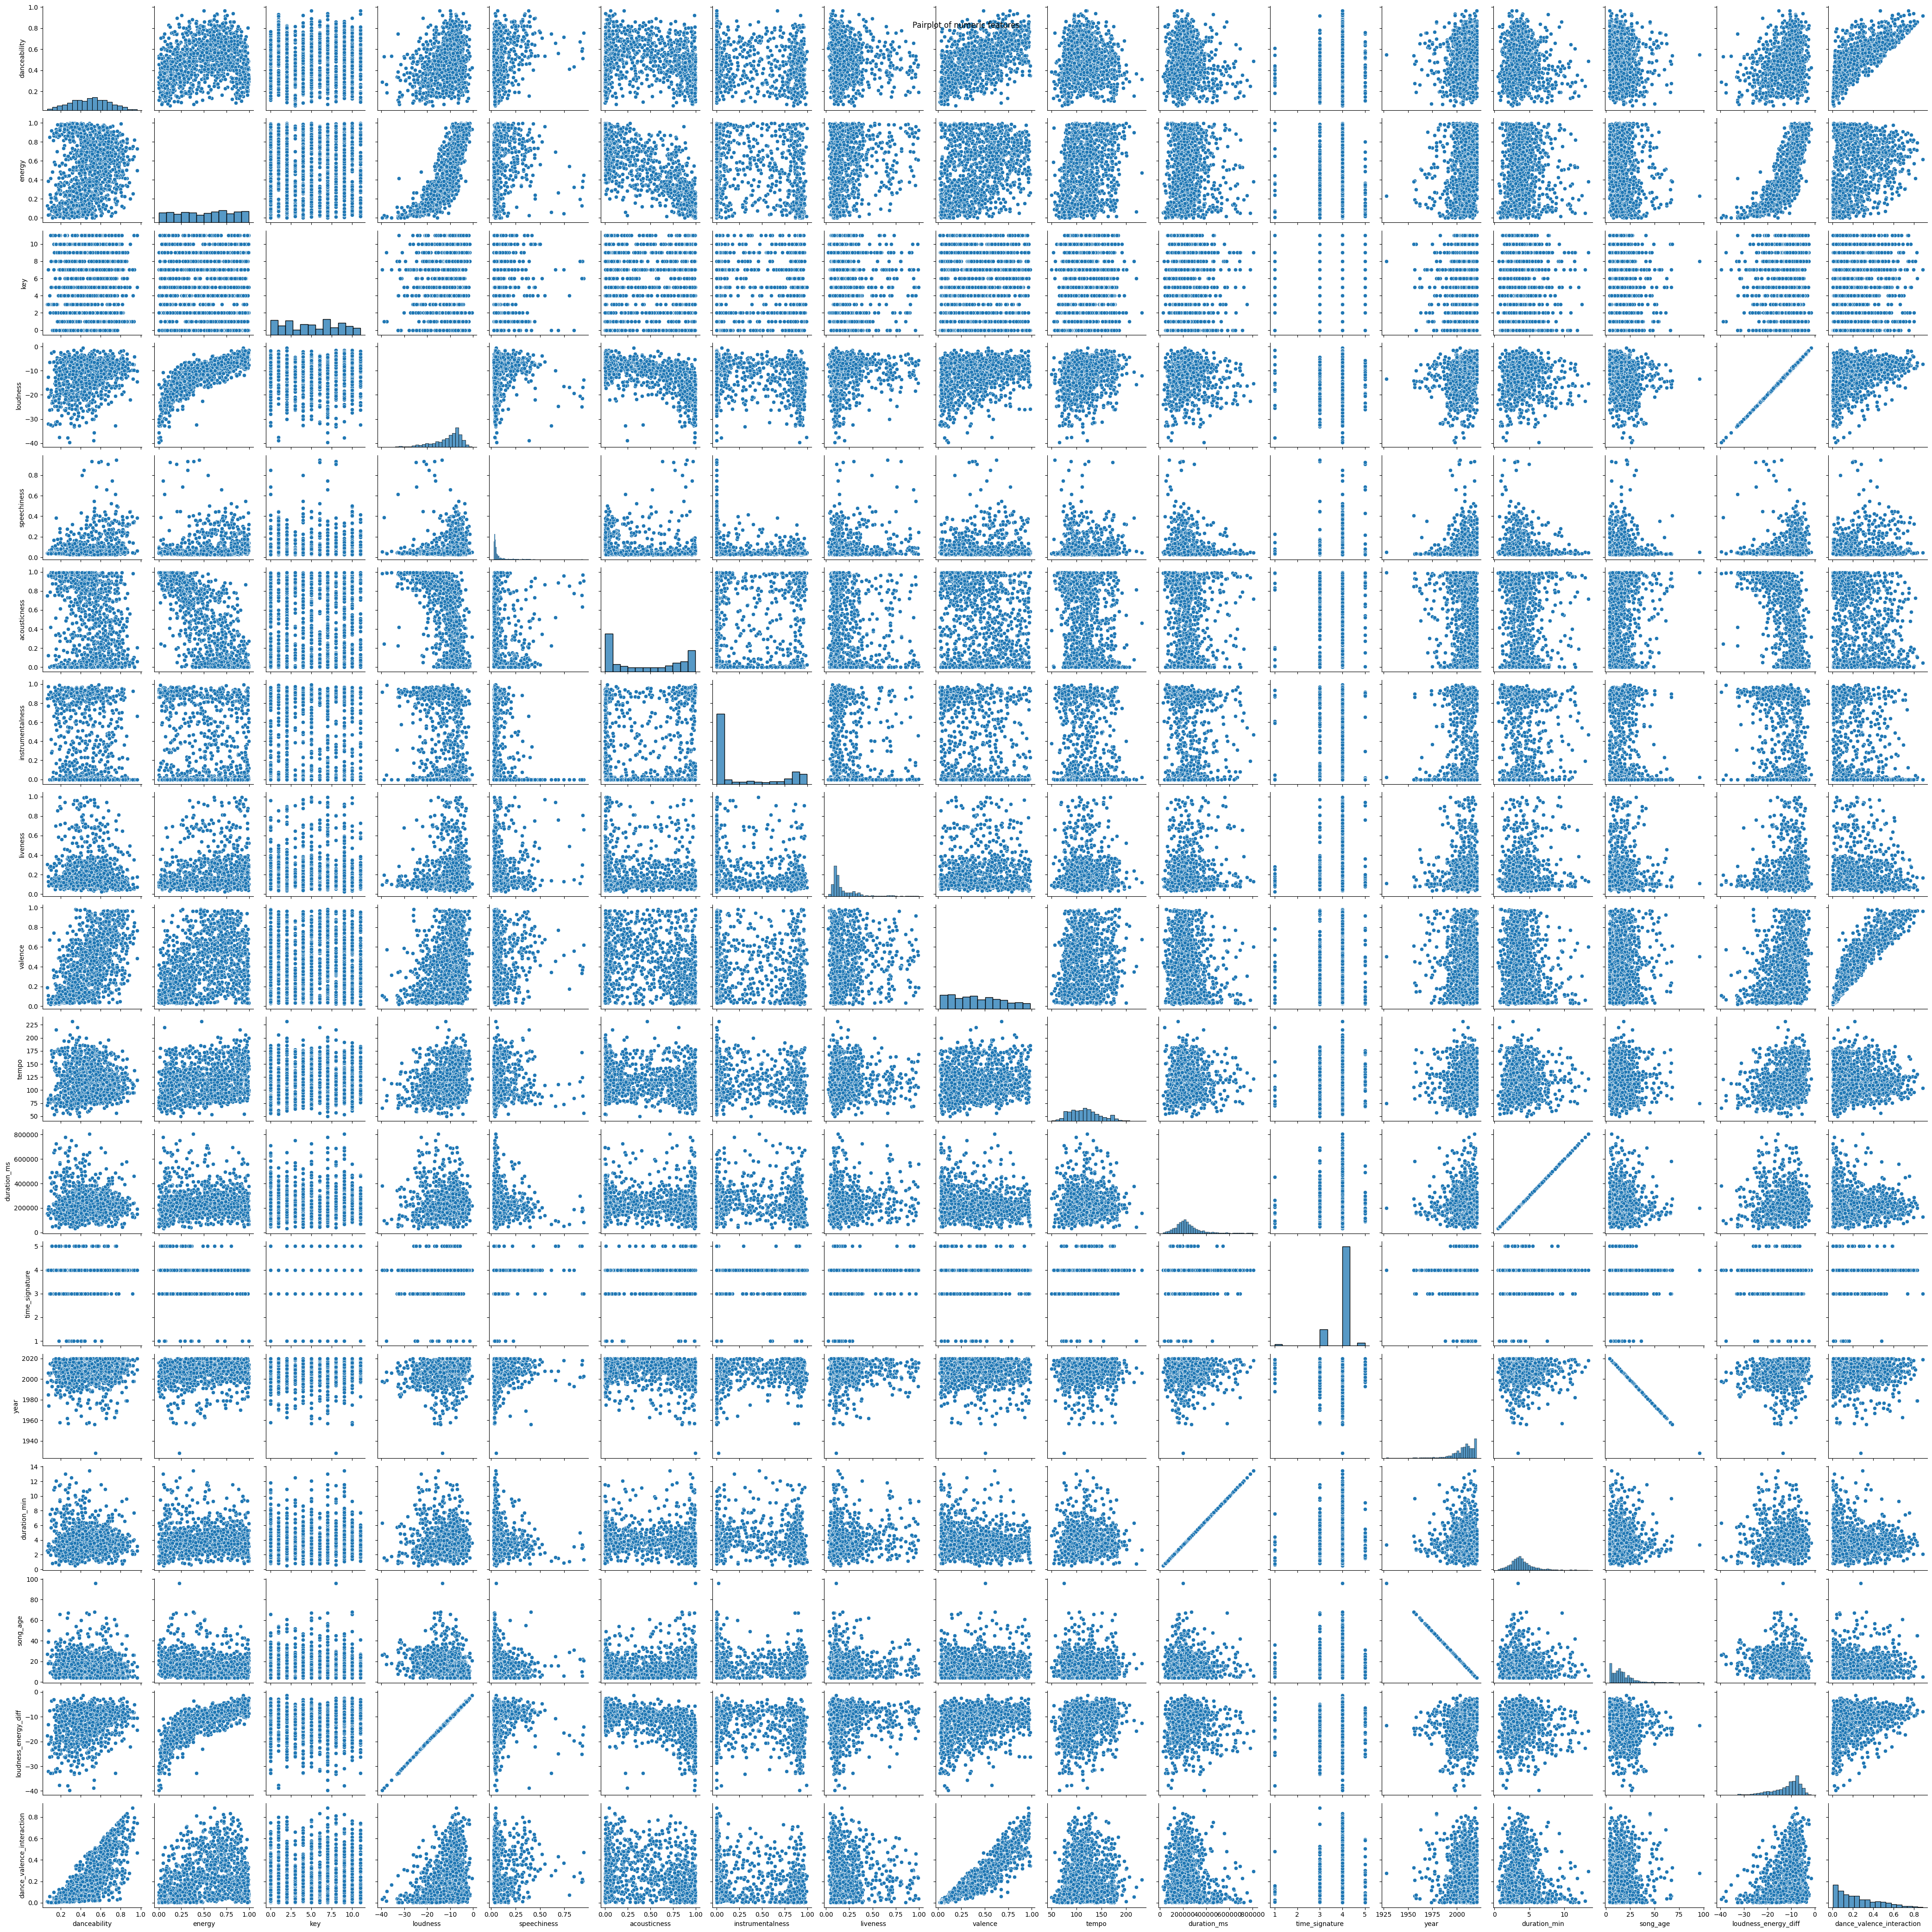

In [45]:
sns.pairplot(numeric_data.sample(.001).toPandas())
plt.suptitle("Pairplot of numeric features")
plt.savefig("../data/pairplot_all.png")
plt.show()

The above pair-plot shows the relationship between the features.


Let's analyze the song length.


In [46]:
song_lengths = df.select("duration_min").collect()
song_lengths = [row["duration_min"] for row in song_lengths]

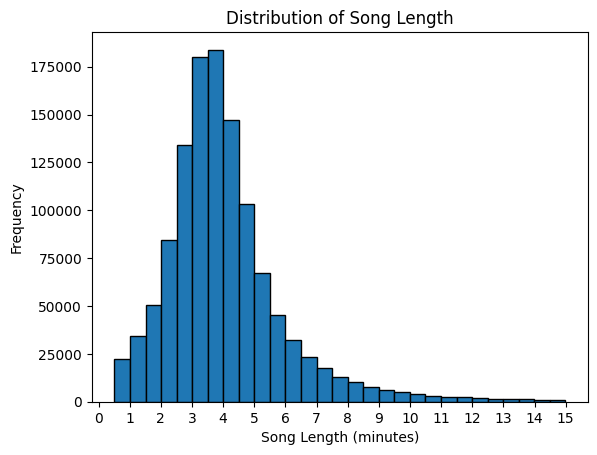

In [47]:
plt.hist(song_lengths, bins=29, edgecolor="black")
plt.xlabel("Song Length (minutes)")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 16, 1))
plt.title("Distribution of Song Length")
plt.show()

As we can see, most of the songs are between 3 to 4 minutes long. Let's also analyze the song length based on the year.


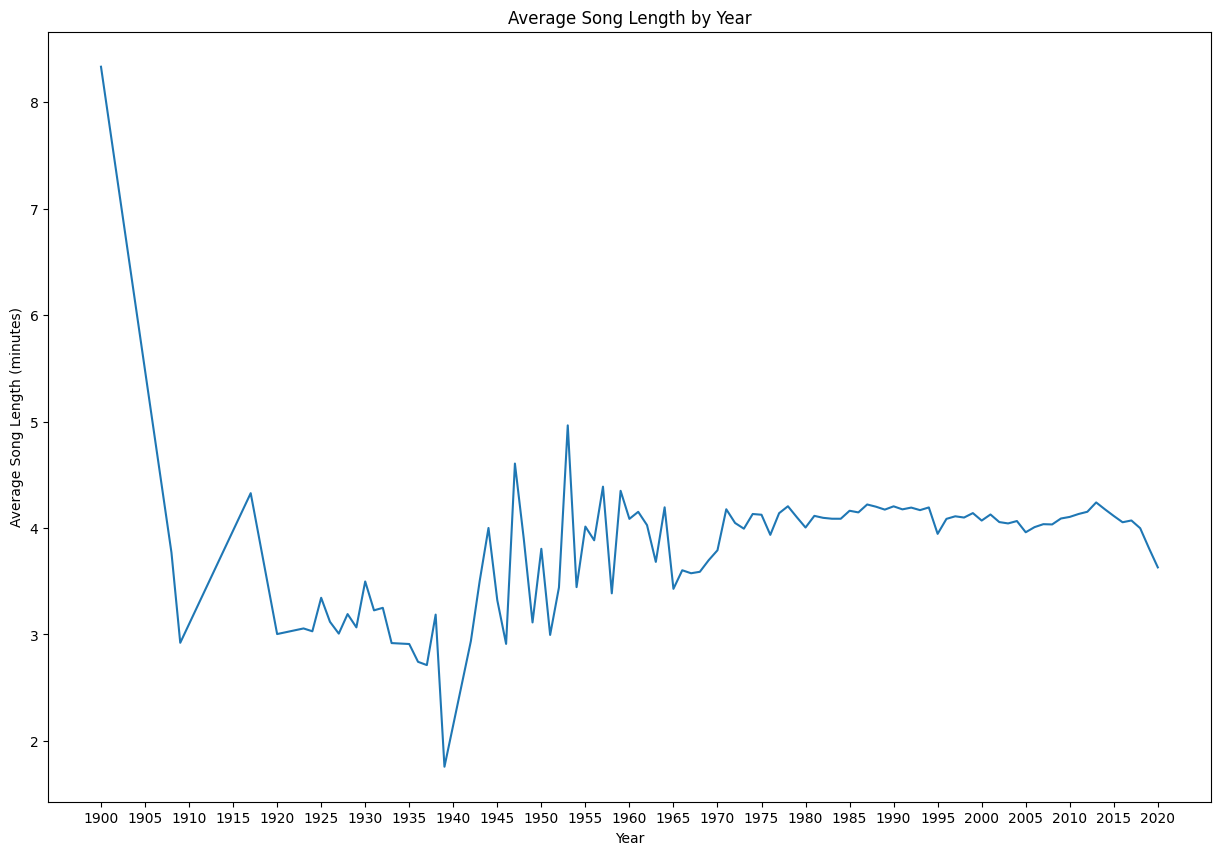

In [48]:
plt.figure(figsize=(15, 10))
plt.plot(year_stats.select("year").collect(), year_stats.select("avg_duration_min").collect())
plt.xlabel("Year")
plt.ylabel("Average Song Length (minutes)")
plt.xticks(np.arange(1900, 2025, 5))
plt.title("Average Song Length by Year")
plt.show()

The average song length did not change significantly over the past years. However, we have a large decrease in the song length in about 1939. In the first years of the dataset, we have significantly fewer songs, so the average song length is not reliable.


In [49]:
song_length_1935_1940 = year_stats.filter((F.col("year") >= 1935) & (F.col("year") <= 1940)).select("year", "avg_duration_min", "count")
show_df(song_length_1935_1940)

+----+------------------+-----+
|year|  avg_duration_min|count|
+----+------------------+-----+
|1935|2.9104999999999994|   20|
|1936|2.7431325301204814|   83|
|1937| 2.712564102564103|   39|
|1938|3.1867307692307705|   52|
|1939| 1.757619047619048|   21|
+----+------------------+-----+

Total number of rows: 5
root
 |-- year: long (nullable = true)
 |-- avg_duration_min: double (nullable = true)
 |-- count: long (nullable = false)



This huge decrease may be because of the beginning of World War II.


We can also plot a violin plot to show the distribution of the song length.


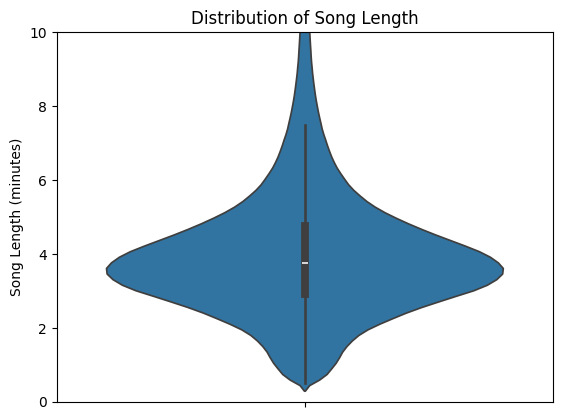

In [50]:
sns.violinplot(y=song_lengths)
plt.ylabel("Song Length (minutes)")
plt.ylim(0, 10)
plt.title("Distribution of Song Length")
plt.show()

We can also plot the distribution of the key of the songs.


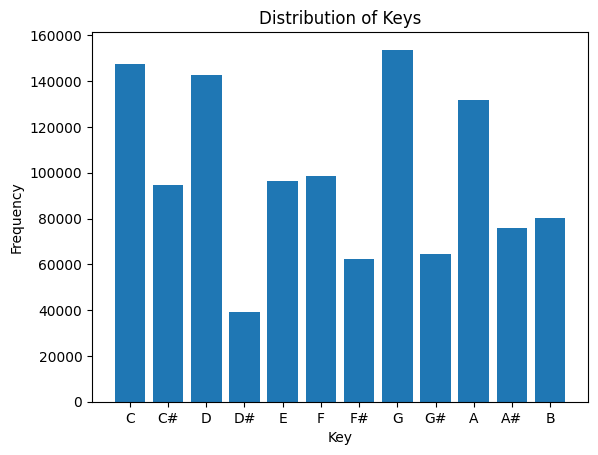

In [51]:
key_counts = df.groupBy("key").count().orderBy("key").collect()
keys = [row["key"] for row in key_counts]
counts = [row["count"] for row in key_counts]

plt.bar(keys, counts)
plt.xlabel("Key")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 12), ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])
plt.title("Distribution of Keys")
plt.show()

Let's also plot the frequency of the day_of_week of the release date.


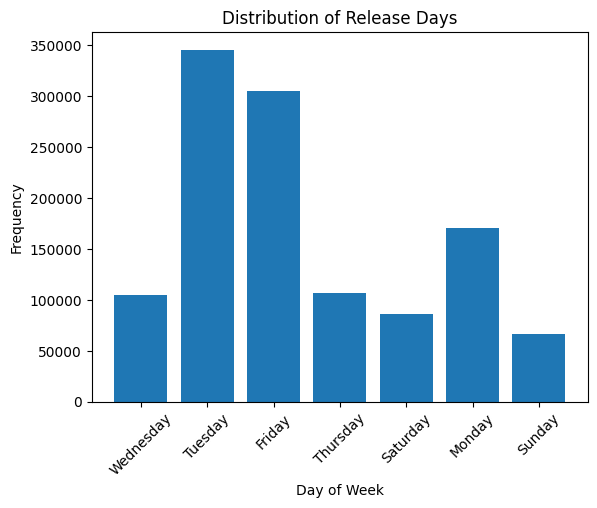

In [52]:
day_of_week_counts = df.groupBy("day_of_week").count().collect()
days = [row["day_of_week"] for row in day_of_week_counts]
counts = [row["count"] for row in day_of_week_counts]

plt.bar(days, counts)
plt.xlabel("Day of Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.title("Distribution of Release Days")
plt.show()

We can see that most of the songs are released on Friday and Tuesday. The reason for this may be that the songs are released on Friday to be listened to during the weekend. Also, Tuesday is a common day for releasing new music because it has the largest gap from Friday which leads to more attention from the audience.


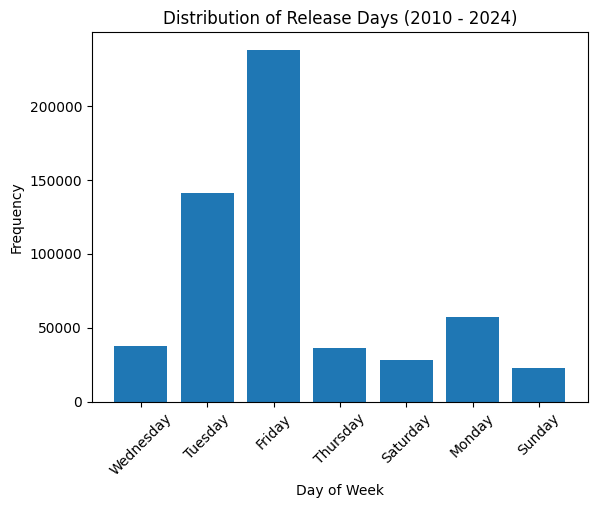

In [53]:
day_of_week_counts = df.filter(F.col("year") >= 2010).groupBy("day_of_week").count().collect()
days = [row["day_of_week"] for row in day_of_week_counts]
counts = [row["count"] for row in day_of_week_counts]

plt.bar(days, counts)
plt.xlabel("Day of Week")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.title("Distribution of Release Days (2010 - 2024)")
plt.show()

We can see that in the past few years, Tuesday was used less than Friday for releasing new songs.


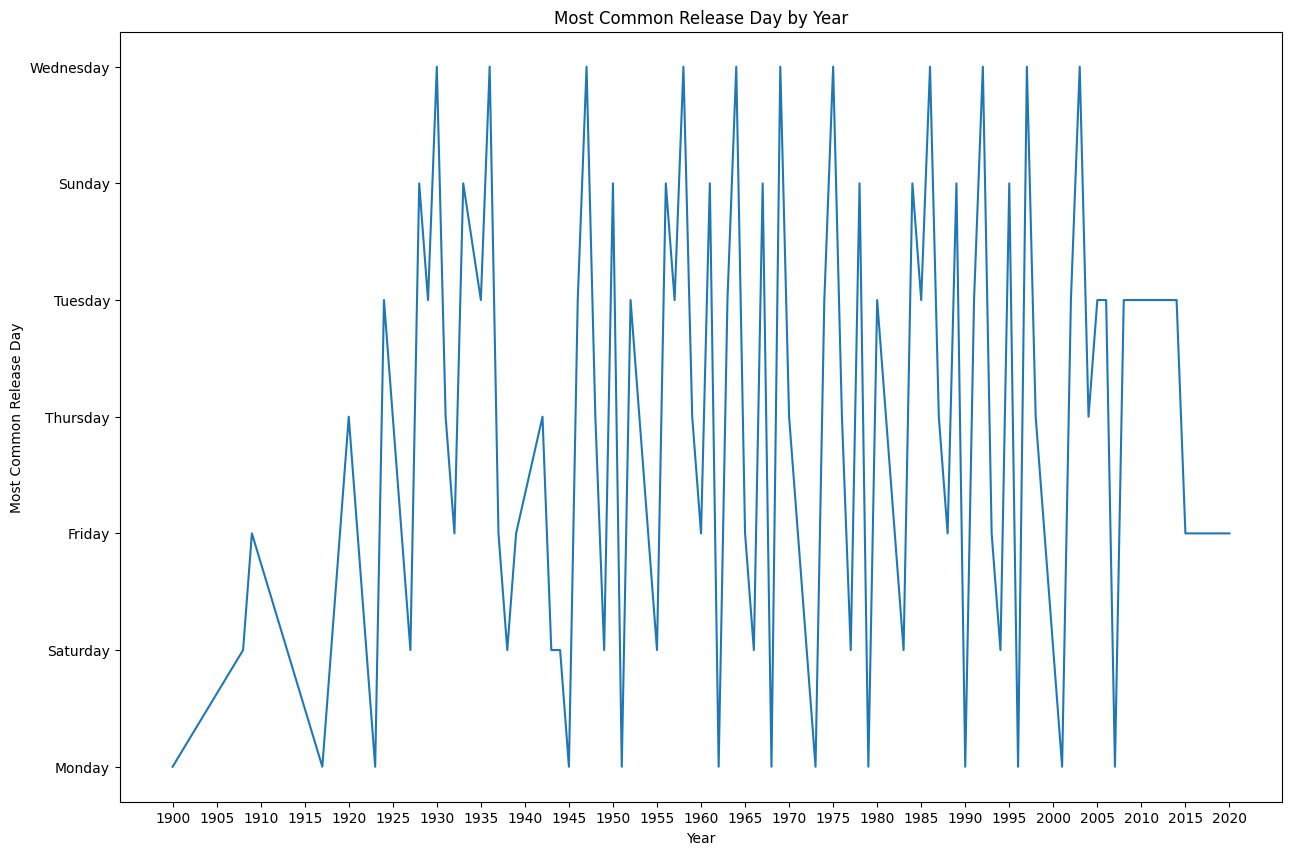

In [54]:
years = year_stats.select("year").collect()
years = [row["year"] for row in years]
day_of_weeks = year_stats.select("mode_day_of_week").collect()
day_of_weeks = [row["mode_day_of_week"] for row in day_of_weeks]

plt.figure(figsize=(15, 10))
plt.plot(years, day_of_weeks)
plt.xlabel("Year")
plt.ylabel("Most Common Release Day")
plt.xticks(np.arange(1900, 2025, 5))
plt.title("Most Common Release Day by Year")
plt.show()

As we can see, the day of week of the songs' release date has changed a lot until 2010. However, after 2010, the day of week of the songs' release date has become more stable. The reason for this may be that the music industry has become more professional and the release date of the songs is planned more carefully. For about 5 years, the songs were released more on Tuesday than Friday. However, after 2015, the songs were released more on Friday than Tuesday.


Now, let's check the distribution of the `is_major` column.


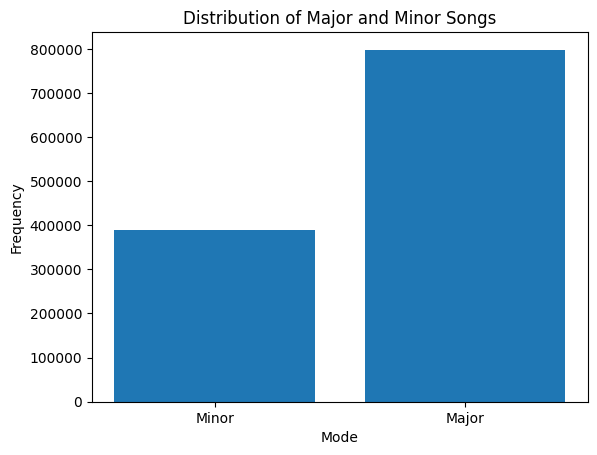

In [55]:
is_major_counts = df.groupBy("is_major").count().collect()
is_major = [row["is_major"] for row in is_major_counts]
counts = [row["count"] for row in is_major_counts]

plt.bar(is_major, counts)
plt.xlabel("Mode")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Minor", "Major"])
plt.title("Distribution of Major and Minor Songs")
plt.show()

As we can see, the number of major songs is about twice the number of minor songs. This means that major songs are more common than minor songs.


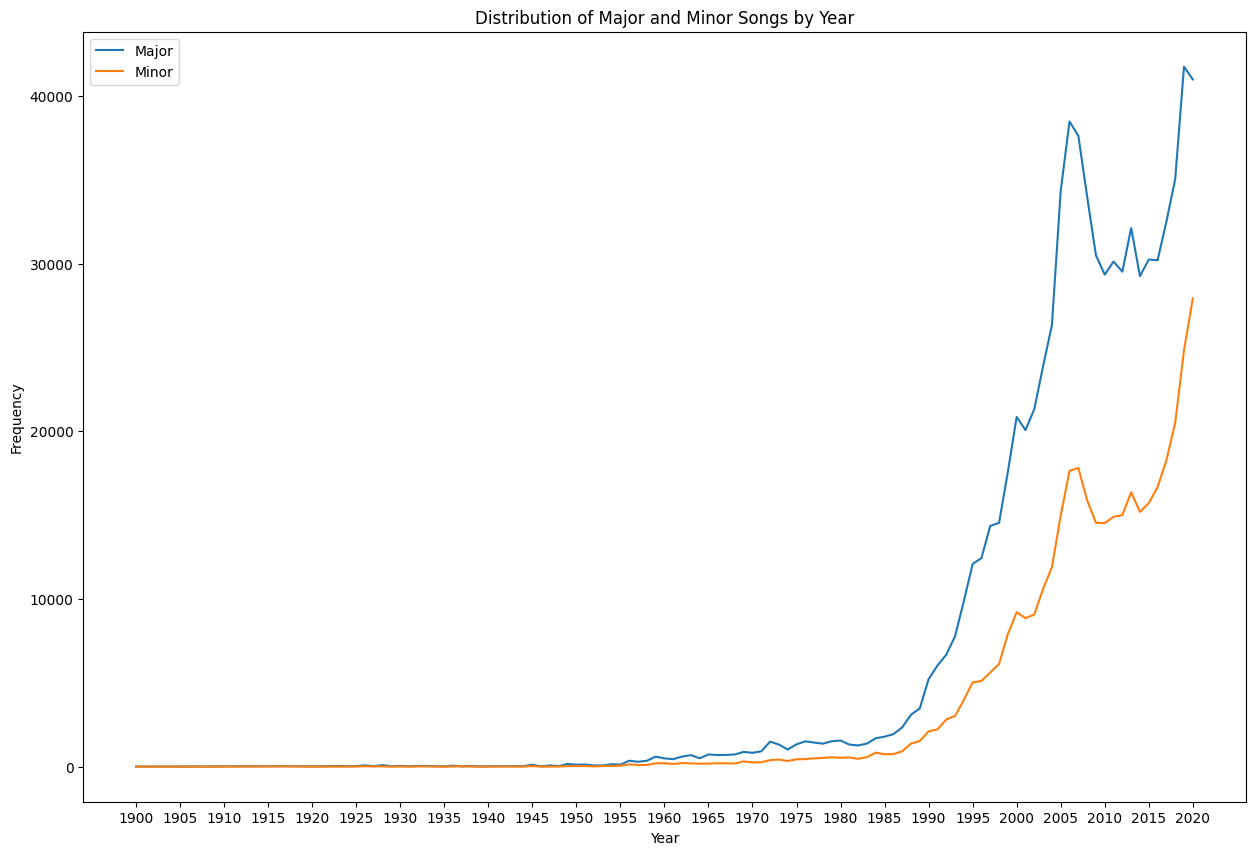

In [56]:
mode_counts = df.groupBy("year", "is_major").count().orderBy("year").collect()
years = list(set([row["year"] for row in mode_counts]))
years.sort()
major_counts = {year: 0 for year in years}
minor_counts = {year: 0 for year in years}
for row in mode_counts:
    if row["is_major"]:
        major_counts[row["year"]] = row["count"]
    else:
        minor_counts[row["year"]] = row["count"]

plt.figure(figsize=(15, 10))
plt.plot(years, list(major_counts.values()), label="Major")
plt.plot(years, list(minor_counts.values()), label="Minor")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(np.arange(1900, 2025, 5))
plt.title("Distribution of Major and Minor Songs by Year")
plt.legend()
plt.show()

We can see that the major songs have always been more that the minor songs. However, the increase in both major and minor songs has the same trend.


Let's also do the above for explicit musics.


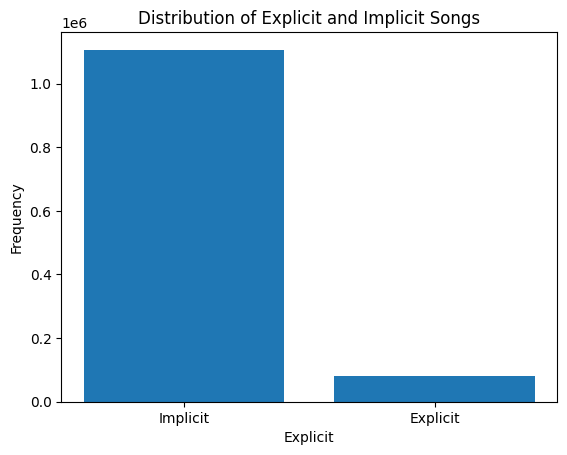

In [57]:
explicit_counts = df.groupBy("explicit").count().collect()
explicit = [row["explicit"] for row in explicit_counts]
counts = [row["count"] for row in explicit_counts]

plt.bar(explicit, counts)
plt.xlabel("Explicit")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["Implicit", "Explicit"])
plt.title("Distribution of Explicit and Implicit Songs")
plt.show()

We can see that only a small percentage of songs are explicit.


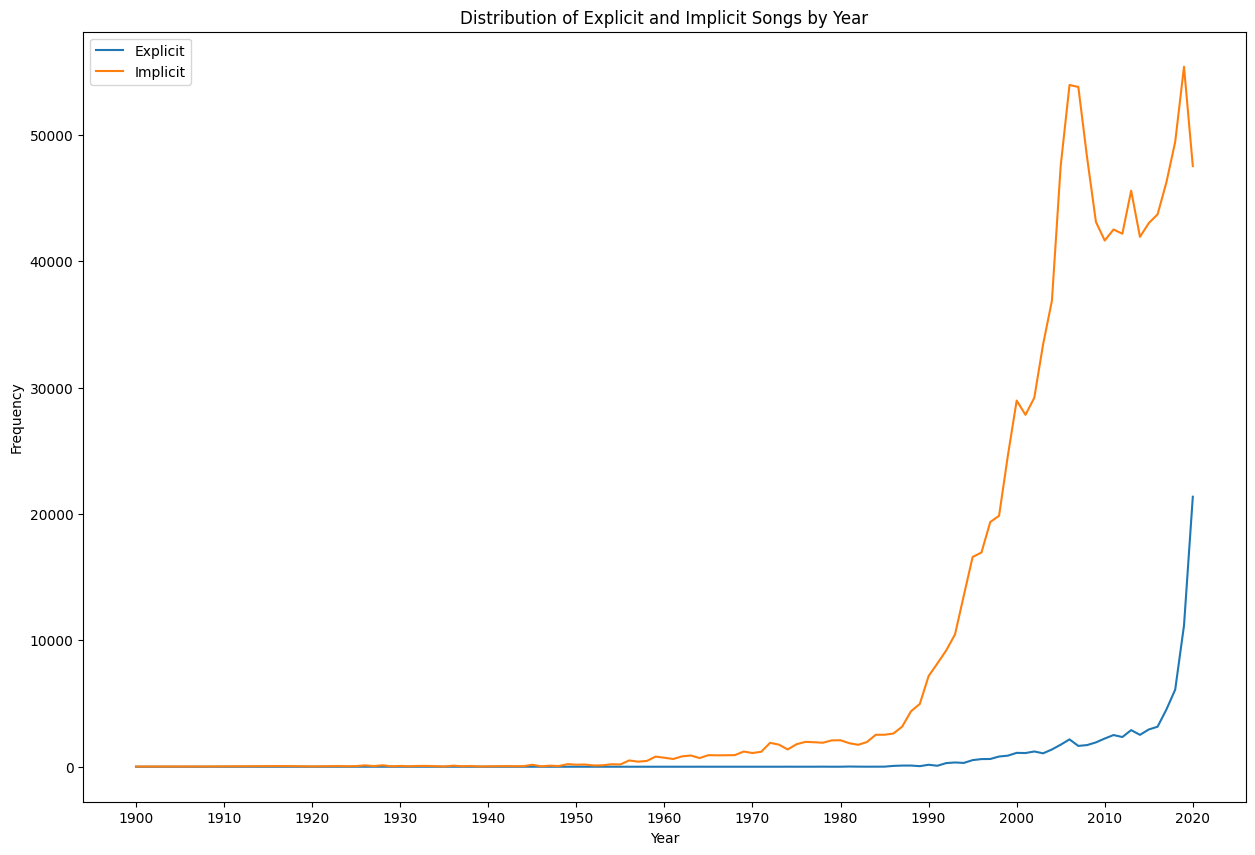

In [58]:
explicits = df.groupBy("year", "explicit").count().orderBy("year").collect()
years = list(set([row["year"] for row in explicits]))
years.sort()
explicit_counts = {year: 0 for year in years}
implicit_counts = {year: 0 for year in years}
for row in explicits:
    if row["explicit"]:
        explicit_counts[row["year"]] = row["count"]
    else:
        implicit_counts[row["year"]] = row["count"]

plt.figure(figsize=(15, 10))
plt.plot(years, list(explicit_counts.values()), label="Explicit")
plt.plot(years, list(implicit_counts.values()), label="Implicit")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(np.arange(1900, 2025, 10))
plt.title("Distribution of Explicit and Implicit Songs by Year")
plt.legend()
plt.show()

We can see that the number of explicit musics has been increased hugely during the past 6 years.


We can also check the number of songs released per year.


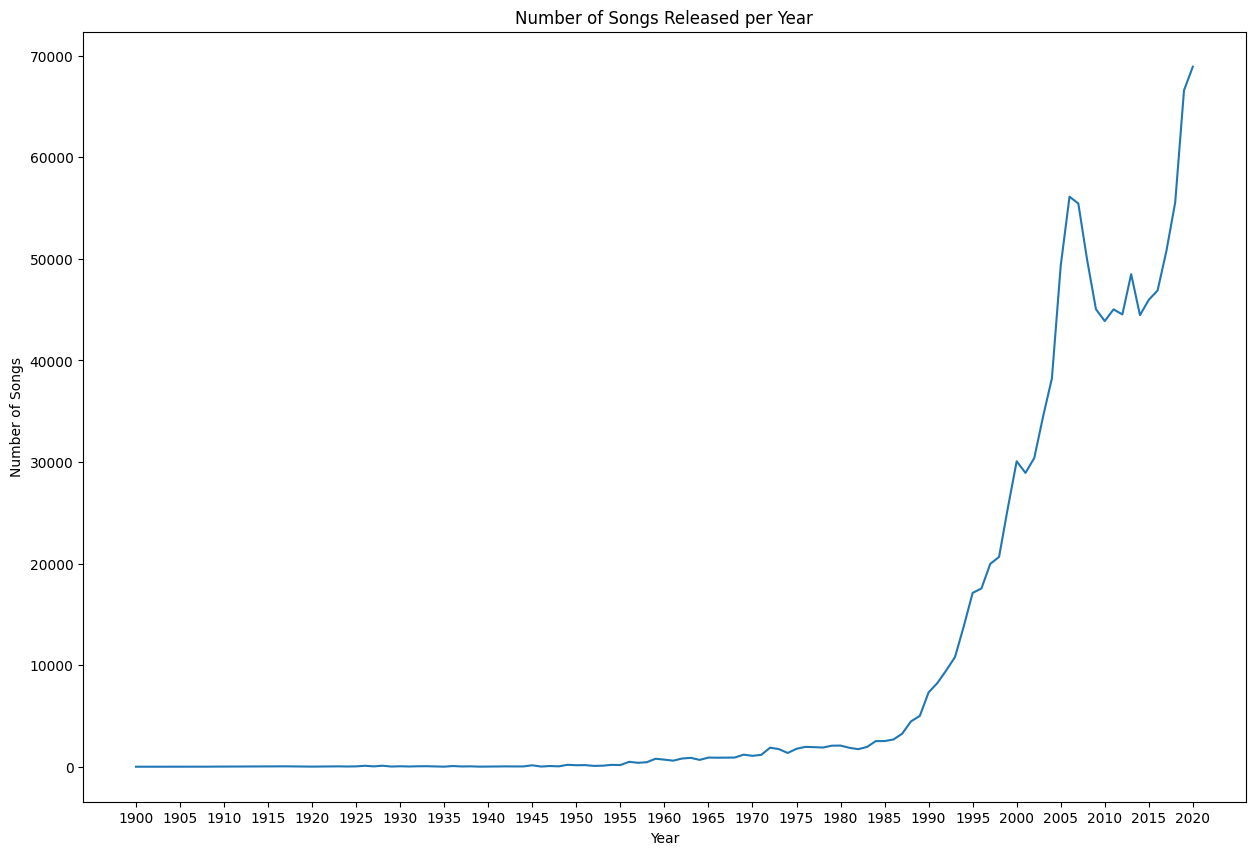

In [59]:
plt.figure(figsize=(15, 10))
plt.plot(year_stats.select("year").collect(), year_stats.select("count").collect())
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.xticks(np.arange(1900, 2025, 5))
plt.title("Number of Songs Released per Year")
plt.show()

As we can see, the overall number of songs released per year has been increased over the years. However, we have a decrease in the number of songs in about 2005 for a few years.


Let's check some of the other columns over the years.


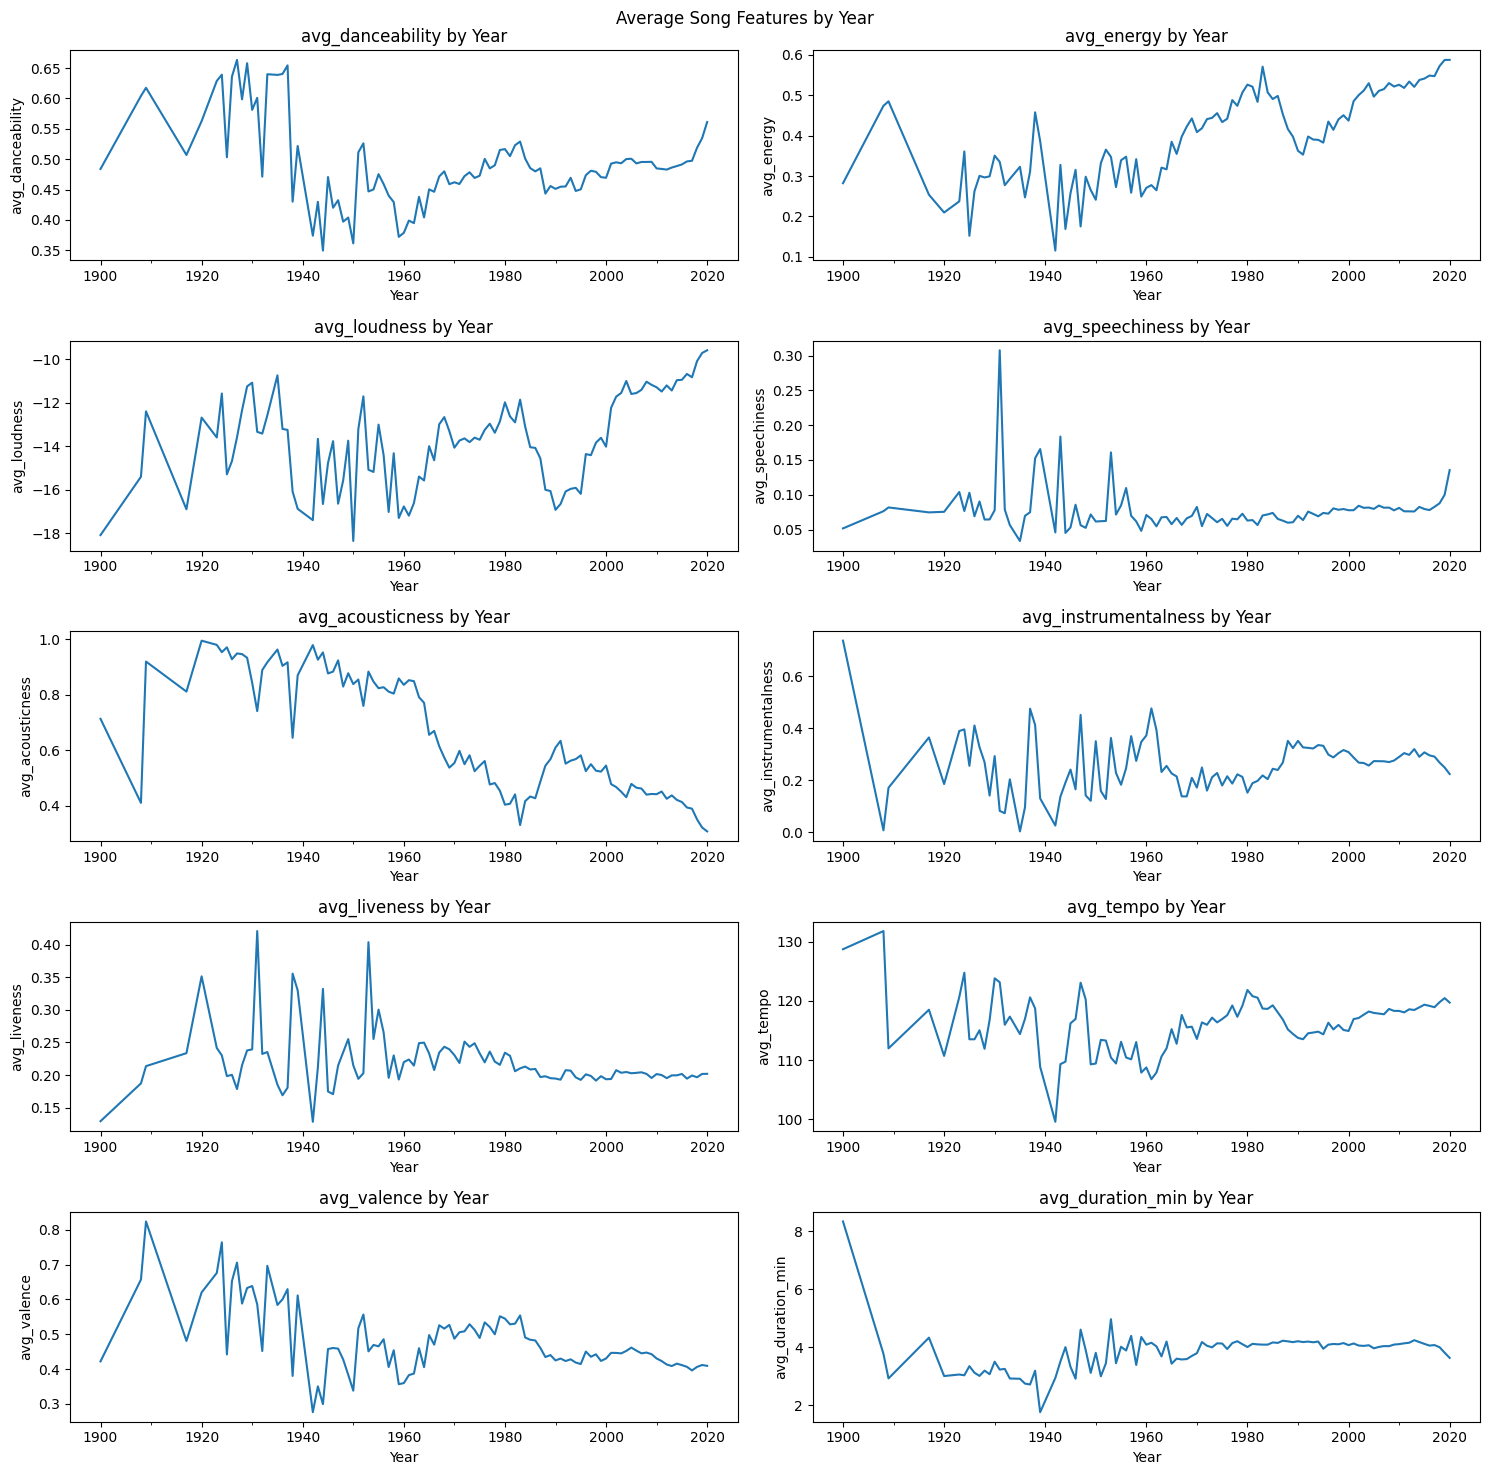

In [60]:
avg_cols = year_stats.columns
avg_cols.remove("year")
avg_cols.remove("count")
avg_cols.remove("mode_day_of_week")

fig, axs = plt.subplots(5, 2, figsize=(15, 15))
fig.suptitle("Average Song Features by Year")

for i, col in enumerate(avg_cols):
    axs[i // 2, i % 2].plot(year_stats.select("year").collect(), year_stats.select(col).collect())
    axs[i // 2, i % 2].set_xlabel("Year")
    axs[i // 2, i % 2].set_ylabel(col)
    axs[i // 2, i % 2].set_xticks(np.arange(1900, 2025, 10), minor=True)
    axs[i // 2, i % 2].set_title(f"{col} by Year")

plt.tight_layout()
plt.show()

All of these features have up and downs over the years. However, we can observe an increase in the following columns in the past few years:

-   Danceability
-   Energy
-   Loudness
-   Speechiness
-   Tempo

The reason for this may be that the music industry has become more professional and the quality of the songs has increased. Also, the music industry has become more competitive and the artists are trying to produce more energetic and danceable songs to attract more audience.

We can observe a decrease in the following columns in the past few years:

-   Acousticness
-   Instrumentalness

This may be because the music industry has become more digital and the artists are trying to produce less acoustic and instrumental songs.

The following columns have been stable over the past few years:

-   Valence
-   Liveness

For the loudness, as we can see the values are negative, and so, they are not in decibels. This column is probably in Loundness Units Full Scale (LUFS), which is a measurement specifically designed for audio loudness. The reference point will be 0 which is the maximum possible digital volume. Negative numbers fall below the reference level in perceived loudness. Spotify uses LUFS to normalize the volume of songs. This means they adjust the loudness of uploaded tracks to a target level (around -14 LUFS) to create a consistent listening experience regardless of the original mastering of the song.


Let's also plot the distribution of some of the columns.


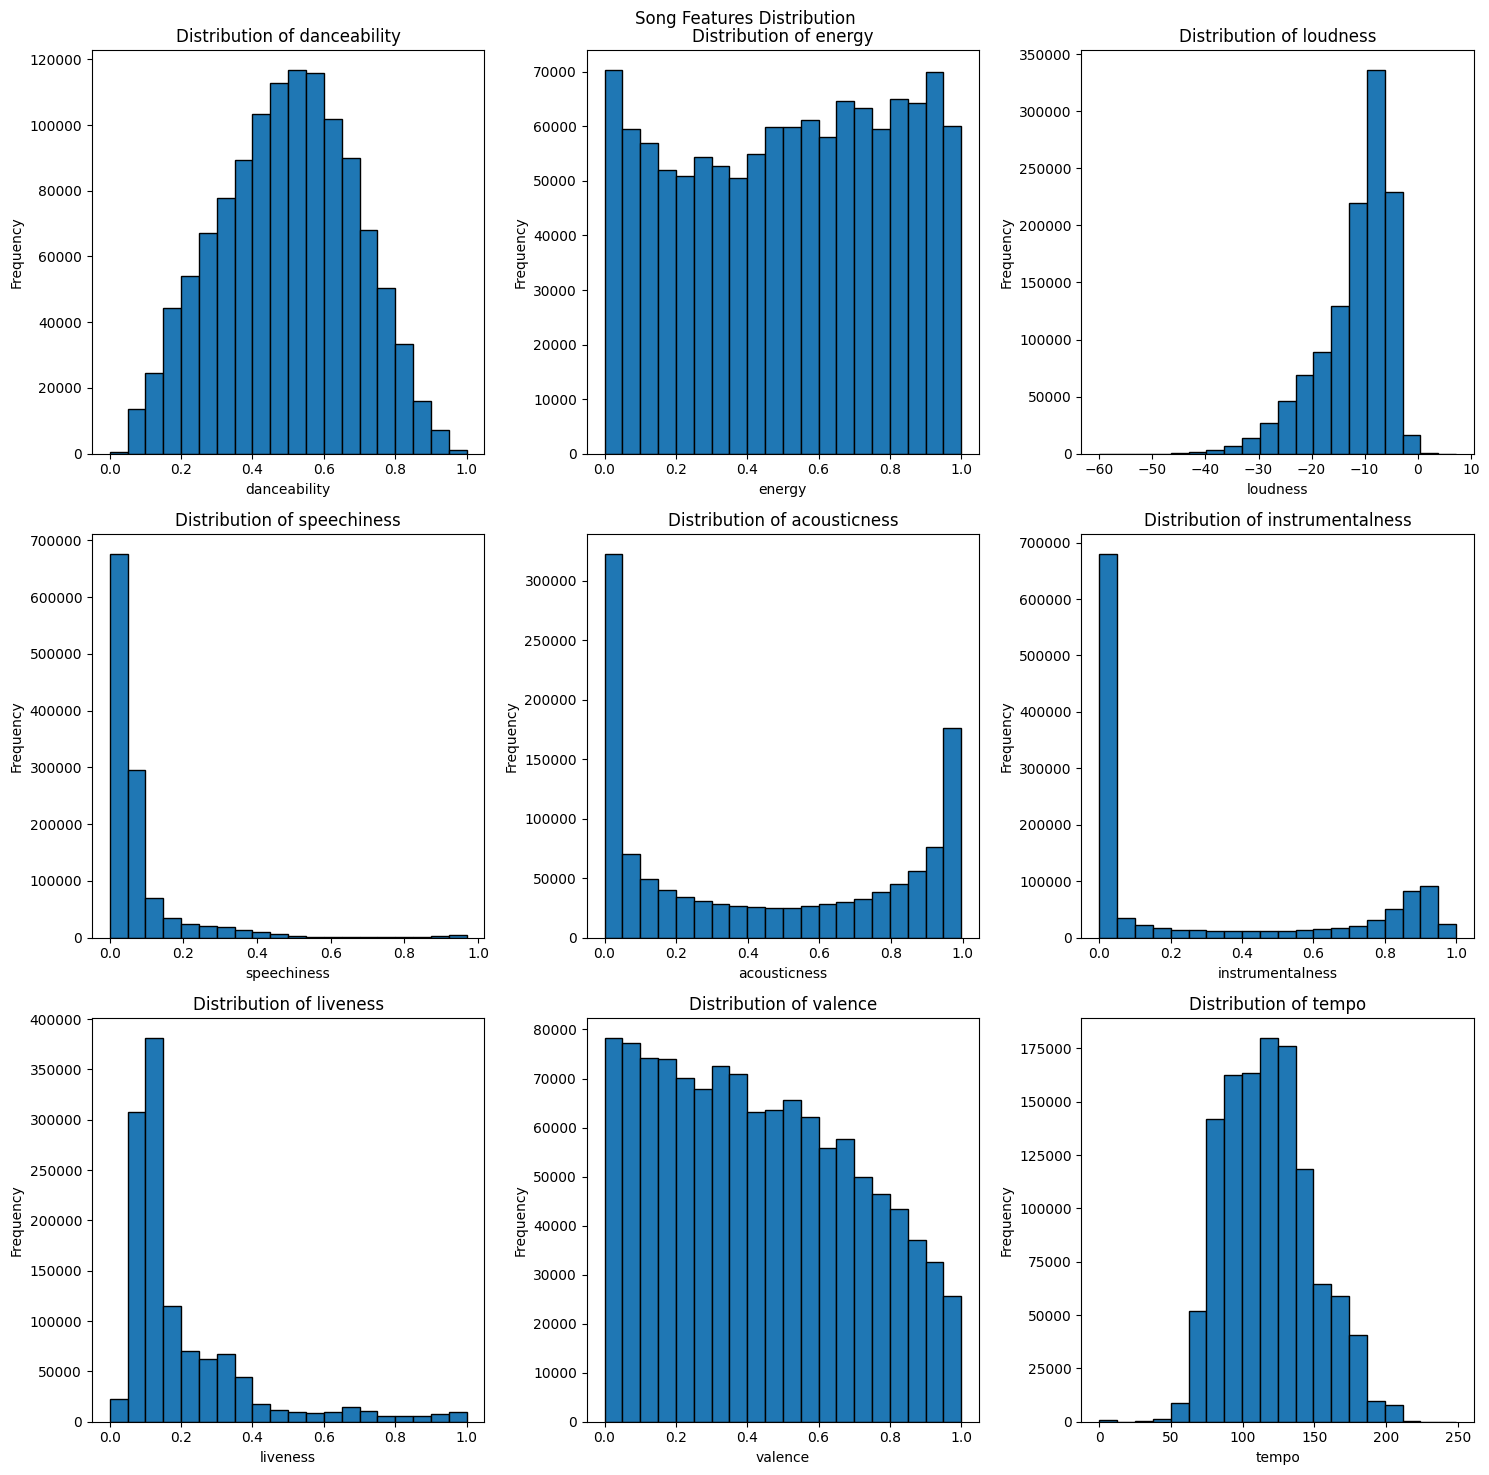

In [67]:
cols = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Song Features Distribution")

for i, col in enumerate(cols):
    data = df.select(col).collect()
    data = [row[col] for row in data]

    axs[i // 3, i % 3].hist(data, bins=20, edgecolor="black")
    axs[i // 3, i % 3].set_xlabel(col)
    axs[i // 3, i % 3].set_ylabel("Frequency")
    axs[i // 3, i % 3].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

As we can see, dancebility and tempo are normally distributed, energy is almost uniformly distributed, valence is almost linearly distributed, acousticness's distribution is beta-like, and the other columns are skewed.


Now, we can check some Top-K Records!


Let's begin with the artists with the most songs.


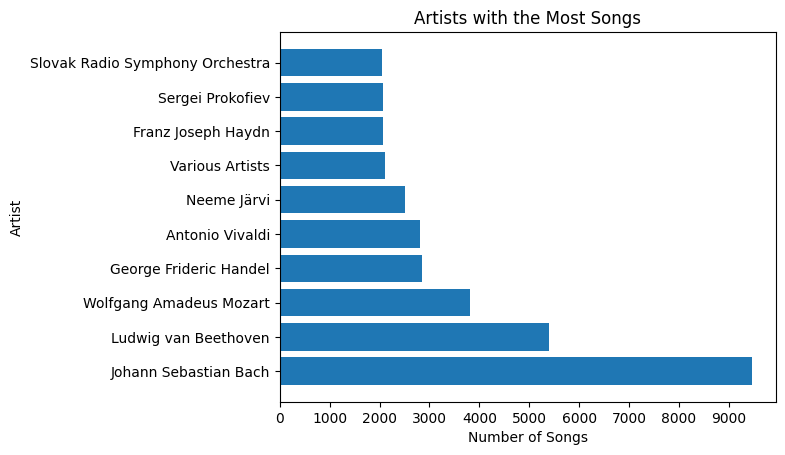

In [70]:
most_songs = df_exploded.groupBy("artist").count().orderBy(F.desc("count")).collect()
most_songs = most_songs[:10]
artists = [row["artist"] for row in most_songs]
counts = [row["count"] for row in most_songs]

plt.barh(artists, counts)
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.xticks(np.arange(0, 10000, 1000))
plt.title("Artists with the Most Songs")
plt.show()

Let's do the same for the albums with most number of songs.


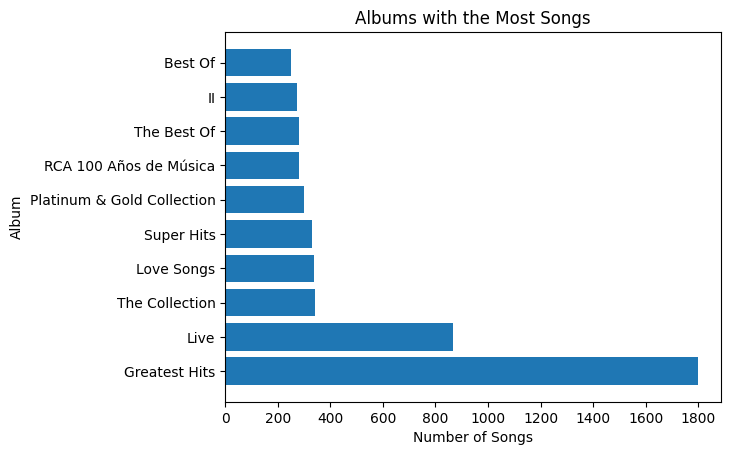

In [74]:
most_songs = df.groupBy("album").count().orderBy(F.desc("count")).collect()
most_songs = most_songs[:10]
albums = [row["album"] for row in most_songs]
counts = [row["count"] for row in most_songs]

plt.barh(albums, counts)
plt.xlabel("Number of Songs")
plt.ylabel("Album")
plt.xticks(np.arange(0, 2000, 200))
plt.title("Albums with the Most Songs")
plt.show()

As we can see, the album with the most number of songs is `Greatest Hits` with about 1800 songs. However, this is not a single album. This is also the case for some of the other albums in the list such as `The Collection`, `Love Songs`, `Super Hits`, `The Best Of` and `Best Of`. Let's check some of the songs in the first album.


In [76]:
greatest_hits = df.filter(F.col("album") == "Greatest Hits").select("name", "album", "track_number", "artists", "year")
greatest_hits.show(n=50)

+--------------------+-------------+------------+--------------------+----+
|                name|        album|track_number|             artists|year|
+--------------------+-------------+------------+--------------------+----+
|          Why Not Me|Greatest Hits|           1|       ['The Judds']|1988|
|Rockin' With The ...|Greatest Hits|           2|       ['The Judds']|1988|
|     Mama He's Crazy|Greatest Hits|           3|       ['The Judds']|1988|
|  Give A Little Love|Greatest Hits|           4|       ['The Judds']|1988|
|Grandpa (Tell Me ...|Greatest Hits|           5|       ['The Judds']|1988|
|     Girls Night Out|Greatest Hits|           6|       ['The Judds']|1988|
|     Change Of Heart|Greatest Hits|           7|       ['The Judds']|1988|
|          Have Mercy|Greatest Hits|           8|       ['The Judds']|1988|
| Cry Myself To Sleep|Greatest Hits|           9|       ['The Judds']|1988|
|       Love Is Alive|Greatest Hits|          10|       ['The Judds']|1988|
|           

As we can see, multiple albums have the same name and they are considered as a single album. One way to solve this issue is to consider the album_id.


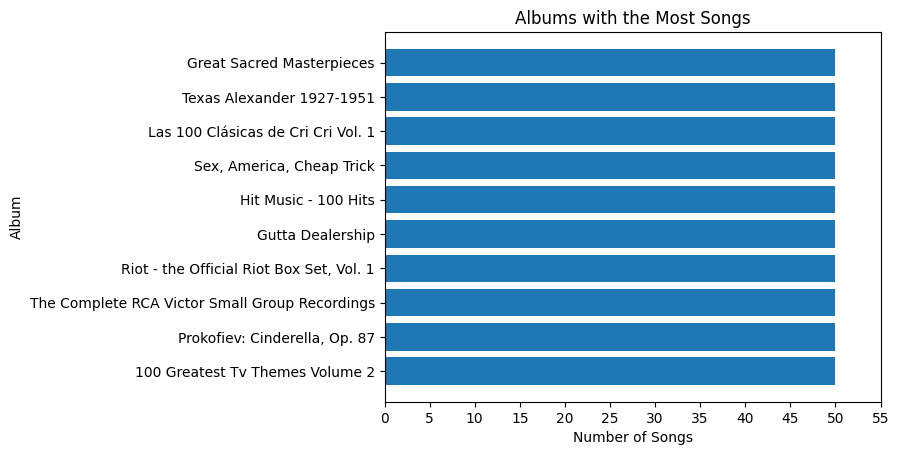

In [81]:
most_songs = df.groupBy("album", "album_id").count().orderBy(F.desc("count")).collect()
most_songs = most_songs[:10]
albums = [row["album"] for row in most_songs]
counts = [row["count"] for row in most_songs]

plt.barh(albums, counts)
plt.xlabel("Number of Songs")
plt.ylabel("Album")
plt.xticks(np.arange(0, 60, 5))
plt.title("Albums with the Most Songs")
plt.show()

As we can see, the result is much more accurate now and the 10 albums with the most number of songs contain 50 songs each.


Let's do the same for artists with the most number of albums.


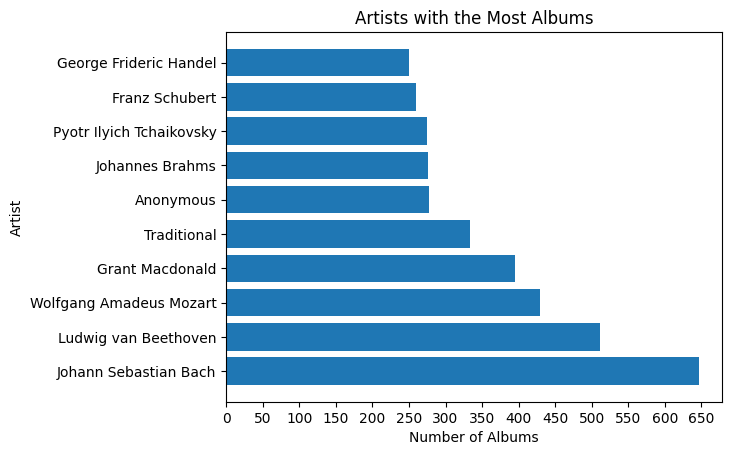

In [85]:
most_albums = df_exploded.groupBy("artist").agg(F.countDistinct("album").alias("count")).orderBy(F.desc("count")).collect()
most_albums = most_albums[:10]
artists = [row["artist"] for row in most_albums]
counts = [row["count"] for row in most_albums]

plt.barh(artists, counts)
plt.xlabel("Number of Albums")
plt.ylabel("Artist")
plt.xticks(np.arange(0, 700, 50))
plt.title("Artists with the Most Albums")
plt.show()

As we can see, the result for the first three is the same as the artists with the most number of songs!


Now, let's go with the artists with the most number of explicit songs.


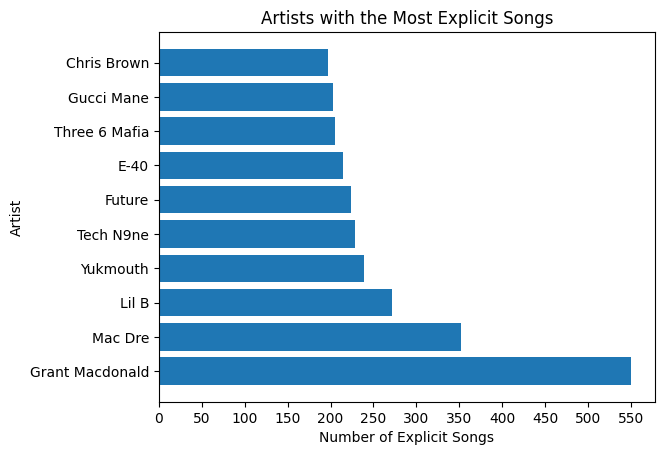

In [91]:
most_explicit = df_exploded.groupBy("artist").agg(F.sum(F.col("explicit").cast("integer")).alias("count")).orderBy(F.desc("count")).collect()
most_explicit = most_explicit[:10]
artists = [row["artist"] for row in most_explicit]
counts = [row["count"] for row in most_explicit]

plt.barh(artists, counts)
plt.xlabel("Number of Explicit Songs")
plt.ylabel("Artist")
plt.xticks(np.arange(0, 600, 50))
plt.title("Artists with the Most Explicit Songs")
plt.show()

We can do the above for the artists with the most number of minor musics.


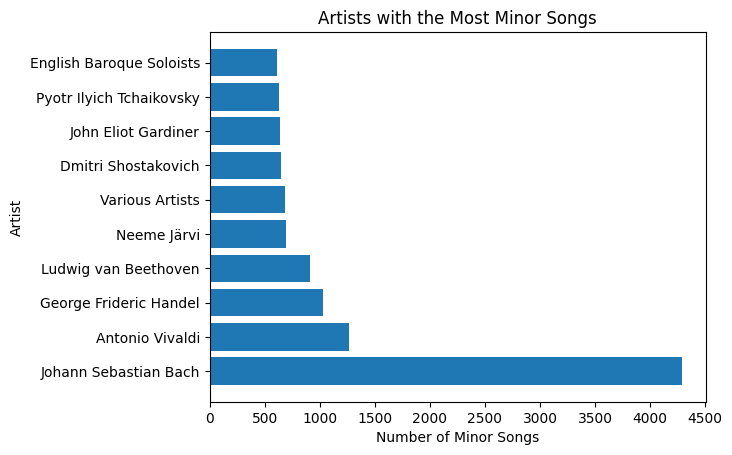

In [95]:
most_minor = df_exploded.filter(F.col("is_major") == False).groupBy("artist").count().orderBy(F.desc("count")).collect()
most_minor = most_minor[:10]
artists = [row["artist"] for row in most_minor]
counts = [row["count"] for row in most_minor]

plt.barh(artists, counts)
plt.xlabel("Number of Minor Songs")
plt.ylabel("Artist")
plt.xticks(np.arange(0, 5000, 500))
plt.title("Artists with the Most Minor Songs")
plt.show()

Let's go with the artists with the most danceable songs.


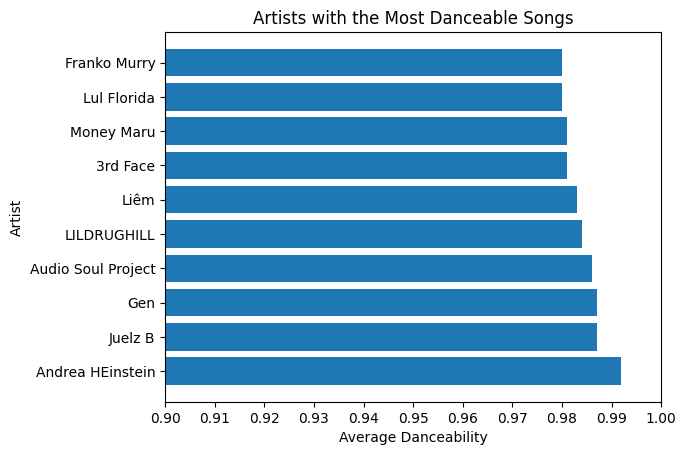

In [113]:
most_danceable = df_exploded.groupBy("artist").agg(F.avg("danceability").alias("avg_danceability")).orderBy(F.desc("avg_danceability")).collect()
most_danceable = most_danceable[:10]
artists = [row["artist"] for row in most_danceable]
danceability = [row["avg_danceability"] for row in most_danceable]

plt.barh(artists, danceability)
plt.xlabel("Average Danceability")
plt.ylabel("Artist")
plt.xlim(0.9, 1)
plt.xticks(np.arange(0.9, 1.01, 0.01))
plt.title("Artists with the Most Danceable Songs")
plt.show()

Let's do the same for the artists with the loudest songs.


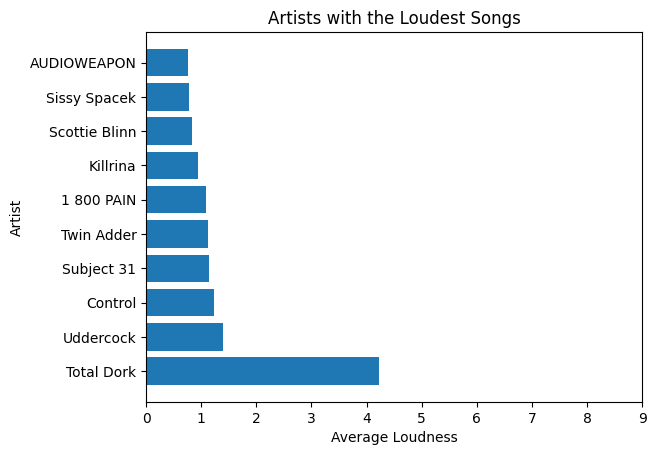

In [99]:
loudest = df_exploded.groupBy("artist").agg(F.avg("loudness").alias("avg_loudness")).orderBy(F.desc("avg_loudness")).collect()
loudest = loudest[:10]
artists = [row["artist"] for row in loudest]
loudness = [row["avg_loudness"] for row in loudest]

plt.barh(artists, loudness)
plt.xlabel("Average Loudness")
plt.ylabel("Artist")
plt.xticks(np.arange(0, 10, 1))
plt.title("Artists with the Loudest Songs")
plt.show()

We can also do the same for the artists with the most energetic songs.


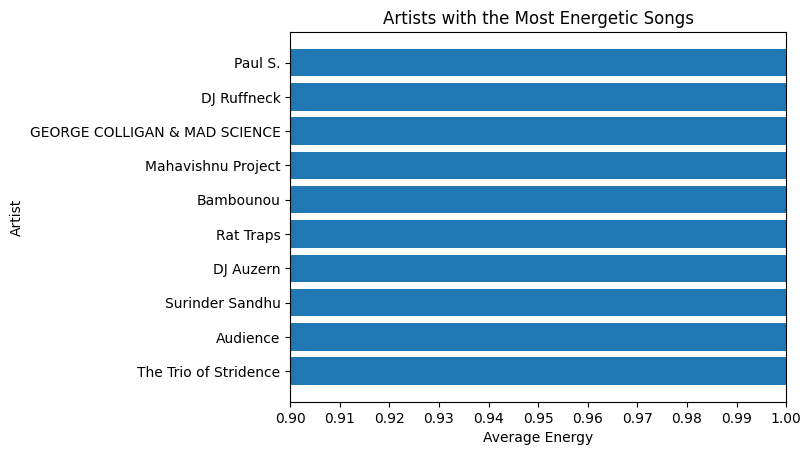

In [111]:
most_energetic = df_exploded.groupBy("artist").agg(F.avg("energy").alias("avg_energy")).orderBy(F.desc("avg_energy")).collect()
most_energetic = most_energetic[:10]
artists = [row["artist"] for row in most_energetic]
energy = [row["avg_energy"] for row in most_energetic]

plt.barh(artists, energy)
plt.xlabel("Average Energy")
plt.ylabel("Artist")
plt.xlim(0.9, 1.0)
plt.xticks(np.arange(0.9, 1.01, 0.01))
plt.title("Artists with the Most Energetic Songs")
plt.show()

Let's also find the albums with the most number of artists.


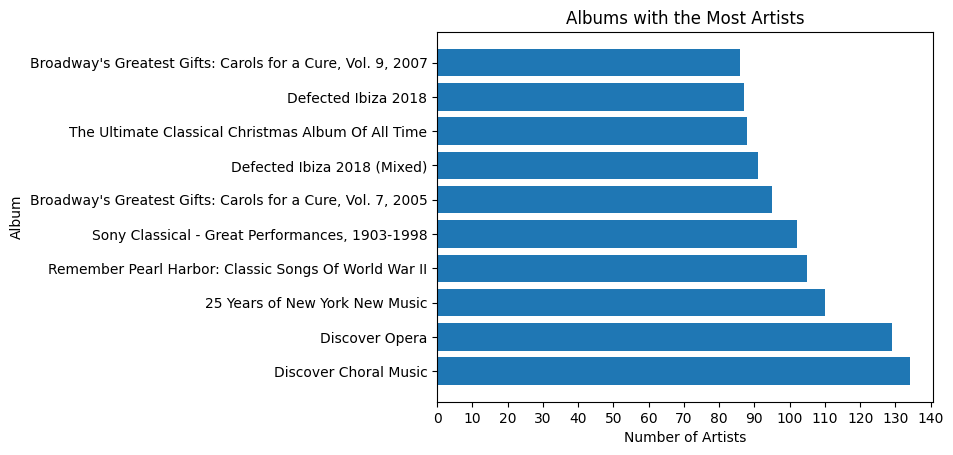

In [103]:
most_artists = df_exploded.groupBy("album_id", "album").agg(F.countDistinct("artist").alias("count")).orderBy(F.desc("count")).collect()
most_artists = most_artists[:10]
albums = [row["album"] for row in most_artists]
counts = [row["count"] for row in most_artists]

plt.barh(albums, counts)
plt.xlabel("Number of Artists")
plt.ylabel("Album")
plt.xticks(np.arange(0, 150, 10))
plt.title("Albums with the Most Artists")
plt.show()

We can find the oldest songs.


In [107]:
oldest_songs = df.orderBy("year").select("name", "artists", "year", "release_date")
oldest_songs.show(n=10, truncate=False)

+----------------------+---------------------+----+------------+
|name                  |artists              |year|release_date|
+----------------------+---------------------+----+------------+
|Arabian Waltz         |['Rabih Abou-Khalil']|1900|1900-01-01  |
|Story Teller          |['Rabih Abou-Khalil']|1900|1900-01-01  |
|Dreams Of A Dying City|['Rabih Abou-Khalil']|1900|1900-01-01  |
|Ornette Never Sleeps  |['Rabih Abou-Khalil']|1900|1900-01-01  |
|Georgina              |['Rabih Abou-Khalil']|1900|1900-01-01  |
|No Visa               |['Rabih Abou-Khalil']|1900|1900-01-01  |
|The Pain After        |['Rabih Abou-Khalil']|1900|1900-01-01  |
|Catania               |['Rabih Abou-Khalil']|1900|1900-01-01  |
|Nashwa                |['Rabih Abou-Khalil']|1900|1900-01-01  |
|An Evening With Jerry |['Rabih Abou-Khalil']|1900|1900-01-01  |
+----------------------+---------------------+----+------------+
only showing top 10 rows



However, as the release dates are 1900-01-01, they may not be the oldest songs.


Let's find the most danceable songs.


In [108]:
most_danceable_songs = df.orderBy(F.desc("danceability")).select("name", "artists", "danceability")
most_danceable_songs.show(n=10, truncate=False)

+------------------------------------+--------------------+------------+
|name                                |artists             |danceability|
+------------------------------------+--------------------+------------+
|Unendlich                           |['Wolfgang Voigt']  |1.0         |
|Na-try Mo Na Ba Ako                 |['Andrew E.']       |0.994       |
|Roll Like Dis / Cha-cha Slide Part 2|['Mr. C']           |0.993       |
|Techno Is Not Fault                 |['Andrea HEinstein']|0.992       |
|Aussie, Aussie (O, Sige!)           |['Andrew E.']       |0.991       |
|Le casse-tête (Cannelle, Pruneau)   |['Passe-Partout']   |0.991       |
|New Life                            |['Matias Aguayo']   |0.99        |
|Esther's Vice                       |['Bexar Bexar']     |0.99        |
|Go Nuts                             |['Edidion']         |0.988       |
|Believe In Love                     |['The Wooden Birds']|0.988       |
+------------------------------------+-------------

Let's do the same for the most energetic and least energetic songs.


In [114]:
most_energetic_songs = df.orderBy(F.desc("energy")).select("name", "artists", "energy")
most_energetic_songs.show(n=10, truncate=False)

+---------------------------+--------------------+------+
|name                       |artists             |energy|
+---------------------------+--------------------+------+
|Untitled 3                 |['KK Null']         |1.0   |
|Dead Walking Machine       |['Adam Kult']       |1.0   |
|Lion & Oil                 |['Times New Viking']|1.0   |
|Did You Cum?               |['Coachwhips']      |1.0   |
|Skald Au Satans Sol        |['Darkthrone']      |1.0   |
|Soft Water Rhinoceros      |['Merzbow']         |1.0   |
|Slottet I Det Fjerne       |['Darkthrone']      |1.0   |
|I En Hall Med Flesk Og Mjod|['Darkthrone']      |1.0   |
|Say No To Emo              |['ESA']             |1.0   |
|Einstein-Rosen Bridge      |['Venetian Snares'] |1.0   |
+---------------------------+--------------------+------+
only showing top 10 rows



In [115]:
least_energetic_songs = df.orderBy("energy").select("name", "artists", "energy")
least_energetic_songs.show(n=10, truncate=False)

+-------------------------------------+-----------------------+------+
|name                                 |artists                |energy|
+-------------------------------------+-----------------------+------+
|Intermission - blank track           |['Frog Eyes']          |0.0   |
|The Party Is Over - Alternate Version|['Lacrimosa']          |0.0   |
|In Remembrance                       |['Pan.Thy.Monium']     |0.0   |
|Silent Track                         |['Robert Earl Keen']   |0.0   |
|Intermission - blank track           |['Frog Eyes']          |0.0   |
|No Hand Signals                      |['Geiom', 'Shortstuff']|0.0   |
|Silence                              |['Papermoon']          |0.0   |
|For Ann (rising)                     |['James Tenney']       |0.0   |
|Two Minutes Silence                  |['Jesters of Destiny'] |0.0   |
|Untitled                             |['Pia Fraus']          |0.0   |
+-------------------------------------+-----------------------+------+
only s

We could also do the same of the loudest and the most quiet songs.


In [116]:
loudest_songs = df.orderBy(F.desc("loudness")).select("name", "artists", "loudness")
loudest_songs.show(n=10, truncate=False)

+------------------------+--------------------+------------------+
|name                    |artists             |loudness          |
+------------------------+--------------------+------------------+
|Bucket                  |['Sissy Spacek']    |7.234             |
|Killer Slook            |['Sissy Spacek']    |6.674             |
|Trim                    |['Sissy Spacek']    |6.627000000000002 |
|Air Horn                |['Sissy Spacek']    |6.1110000000000015|
|Unnecessary Conversation|['Sissy Spacek']    |6.037999999999999 |
|Spirant (Mix)           |['Sissy Spacek']    |5.399             |
|Spiral Blast            |['Merzbow']         |5.118             |
|My Station Rock         |['Merzbow']         |5.048             |
|OH                      |['The Intelligence']|4.651             |
|Woodpecker No. 2        |['Merzbow']         |4.615             |
+------------------------+--------------------+------------------+
only showing top 10 rows



In [117]:
most_quiet_songs = df.orderBy("loudness").select("name", "artists", "loudness")
most_quiet_songs.show(n=10, truncate=False)

+------------------------------------+--------------------------+--------+
|name                                |artists                   |loudness|
+------------------------------------+--------------------------+--------+
|Two Minutes Silence                 |['Jesters of Destiny']    |-60.0   |
|track 16                            |['Maggi, Pierce And E.J.']|-60.0   |
|Untitled                            |['Pia Fraus']             |-60.0   |
|Silence                             |['Papermoon']             |-60.0   |
|Silent Track                        |['Robert Earl Keen']      |-60.0   |
|15 Minutes Blank (no Music)         |['Butch Walker']          |-60.0   |
|Intermission - blank track          |['Frog Eyes']             |-60.0   |
|Painstakingly Concealed Secret Track|['MC Frontalot']          |-60.0   |
|Wardenclyffe                        |['Geiom', 'Shortstuff']   |-60.0   |
|Intermission - blank track          |['Frog Eyes']             |-60.0   |
+------------------------

As we can see, some of these tracks' names are silent or silence =)


We can also do the same for the most and least valence songs.


In [118]:
most_valence_songs = df.orderBy(F.desc("valence")).select("name", "artists", "valence")
most_valence_songs.show(n=10, truncate=False)

+-------------------------------------------------------+-------------------------------------+-------+
|name                                                   |artists                              |valence|
+-------------------------------------------------------+-------------------------------------+-------+
|La Petacona                                            |['Cuhamileros de la sierra de Xichu']|1.0    |
|Give Thanks in All Circumstances (Instrumental Version)|['The Harrow Family']                |1.0    |
|The Whistling Song                                     |['The Pinker Tones']                 |1.0    |
|Itsy Bitsy Spider                                      |['Jack Hartmann']                    |1.0    |
|Breakbeat 4                                            |['Dj Swamp']                         |1.0    |
|Jim Coleman's / Spellan's Fiddle                       |['Harry Bradley']                    |1.0    |
|Dain's Mill                                            |['Bella

In [119]:
least_valence_songs = df.orderBy("valence").select("name", "artists", "valence")
least_valence_songs.show(n=10, truncate=False)

+---------------------------------------------------+---------------------------------------------------------------+-------+
|name                                               |artists                                                        |valence|
+---------------------------------------------------+---------------------------------------------------------------+-------+
|Sikertelenség                                      |['Venetian Snares']                                            |0.0    |
|15-19Hz                                            |['Bass Mekanik']                                               |0.0    |
|Moment 10                                          |['Lull']                                                       |0.0    |
|10-14Hz                                            |['Bass Mekanik']                                               |0.0    |
|Concerto Grosso in F Major, Op. 1, No. 1: IV. Largo|['Pietro Locatelli', 'Capella Istropolitana', 'Jaroslav Krcek']|0

Ans the same for the songs with the highest and lowest tempo!


In [120]:
highest_tempo_songs = df.orderBy(F.desc("tempo")).select("name", "artists", "tempo")
highest_tempo_songs.show(n=10, truncate=False)

+-----------------------+------------------+------------------+
|name                   |artists           |tempo             |
+-----------------------+------------------+------------------+
|Trap Addict            |['UNDERCODEINE']  |248.93400000000003|
|Nxnc - Original Mix    |['ToBee']         |247.996           |
|Follow You Down - Mixed|['Just Her']      |246.883           |
|Pecan                  |['MICROFUNK']     |246.13            |
|Tubass 1.2             |['Wolfgang Voigt']|245.965           |
|Driving Wheel          |['Syl Johnson']   |245.941           |
|Reunion                |['Grace Brancale']|245.284           |
|The Holy Mountain      |['Poppy']         |244.613           |
|Don't Cross Myrtle     |['Big Lazy']      |244.242           |
|Surrender to Love      |['Grace Brancale']|244.21400000000003|
+-----------------------+------------------+------------------+
only showing top 10 rows



In [121]:
lowest_tempo_songs = df.orderBy("tempo").select("name", "artists", "tempo")
lowest_tempo_songs.show(n=10, truncate=False)

+---------------------------------------------------+---------------------------------------------------------------+-----+
|name                                               |artists                                                        |tempo|
+---------------------------------------------------+---------------------------------------------------------------+-----+
|In Remembrance                                     |['Pan.Thy.Monium']                                             |0.0  |
|ääniesineitâ 1                                     |['antti rannisto']                                             |0.0  |
|belowmeal                                          |['Malcom Kipe']                                                |0.0  |
|Concerto Grosso in F Major, Op. 1, No. 1: IV. Largo|['Pietro Locatelli', 'Capella Istropolitana', 'Jaroslav Krcek']|0.0  |
|Turkish Tension                                    |['Orbital']                                                    |0.0  |
|Moment 

Let's do some other analysis!


In [122]:
res_energy_loudness = df.select(F.corr("energy", "loudness").alias("correlation"))
print(f"Correlation between energy and loudness: {res_energy_loudness.collect()[0].correlation}")
res_energy_danceability = df.select(F.corr("energy", "danceability").alias("correlation"))
print(f"Correlation between energy and danceability: {res_energy_danceability.collect()[0].correlation}")

Correlation between energy and loudness: 0.8200684166151233
Correlation between energy and danceability: 0.27959671112177276


As we can see, the correlation between energy and loudness is much higher than energy and danceability.


In [123]:
res_danceability_valence = df.select(F.corr("danceability", "valence").alias("correlation"))
print(f"Correlation between danceability and valence: {res_danceability_valence.collect()[0].correlation}")
res_energy_valence = df.select(F.corr("energy", "valence").alias("correlation"))
print(f"Correlation between energy and valence: {res_energy_valence.collect()[0].correlation}")

Correlation between danceability and valence: 0.5575348330572455
Correlation between energy and valence: 0.39880209121382637


However, the correlation between danceability and valence is higher than energy and valence.


Let's use a simple formula to calculate the mood of the songs.


In [125]:
moods = df.withColumn("mood", F.when((df["energy"] > 0.5) & (df["danceability"] > 0.5), "High Energy Danceable")
                      .otherwise(F.when((df["energy"] <= 0.5) & (df["danceability"] > 0.5), "Low Energy Danceable")
                      .otherwise(F.when((df["energy"] > 0.5) & (df["danceability"] <= 0.5), "High Energy Not Danceable")
                      .otherwise("Low Energy Not Danceable"))))

moods.groupBy("mood").count().show(truncate=False)

+-------------------------+------+
|mood                     |count |
+-------------------------+------+
|High Energy Danceable    |380895|
|Low Energy Not Danceable |345885|
|High Energy Not Danceable|243947|
|Low Energy Danceable     |217315|
+-------------------------+------+



Let's find the average danceability and energy if we divide the songs into two groups by valence.


In [126]:
df.filter(df.valence > 0.5).agg({"danceability": "mean", "energy": "mean"}).show()
df.filter(df.valence <= 0.5).agg({"danceability": "mean", "energy": "mean"}).show()

+------------------+------------------+
| avg(danceability)|       avg(energy)|
+------------------+------------------+
|0.5976686163817222|0.6274712331176322|
+------------------+------------------+

+------------------+-------------------+
| avg(danceability)|        avg(energy)|
+------------------+-------------------+
|0.4271066100387676|0.43520325184475056|
+------------------+-------------------+



As we can see, when the valence is more than 0.5, the average danceability and energy is higher than the case that valence is less than 0.5.


## Questions

1. **Read about how Spark and Hadoop work. What does the term 'lazy evaluation' mean for them? Explain with a simple example.**

    Hadoop is a framework that allows for the distributed processing of large data sets across clusters of computers using simple programming models. The difference between Spark and Hadoop is that Spark is a data processing tool that operates on distributed data collections, while Hadoop is a distributed data storage and processing tool. Spark is faster than Hadoop because it caches the data in memory, while Hadoop writes the data to disk after each operation. Lazy evaluation is a strategy that delays the evaluation of an expression until its value is actually needed. This can help to optimize the performance of the program by avoiding unnecessary computations. For example, in Spark, transformations are not executed until an action is called. This allows Spark to optimize the execution plan and avoid unnecessary computations. When actions such as `collect()` or `show()` are called, Spark will execute the transformations and return the result.

2. **Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.**

    Parquet files are columnar storage files that store data in a columnar format, which allows for more efficient data processing. These files are highly optimized for query performance and can be read and written much faster than other file formats like CSV. They store data in a compressed format, which reduces the amount of disk space required to store the data. Parquet files also store metadata about the data, which allows for more efficient query processing. Also, These files are splittable, which means that they can be read in parallel by multiple processes, making them ideal for distributed data processing frameworks like Spark.

3. **As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.**

    Spark doesn't save checkpoints by default, but we can enforce it to do so by using the `checkpoint()` method. This method allows us to save the intermediate results of a computation to disk, so that we can resume the computation from that point in case of a failure. This can be useful when we have multiple computation steps and we don't want to wait a lot for the result. By saving the intermediate results to disk, we can avoid recomputing the entire computation in case of a failure. To enforce Spark to save checkpoints, we can call the `checkpoint()` method on the RDD or DataFrame that we want to save. For example, we can call `df.checkpoint()` to save the DataFrame `df` to disk.

4. **Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?**

    To save data so that we could filter it based on specific columns faster than regular filtering, we can use partitioning. Partitioning is a technique that allows us to organize the data into directories based on the values of one or more columns. This allows us to filter the data based on the partition columns, which can significantly improve the query performance. For example, if we have a dataset that contains daily data, we can partition the data by date. This will create a directory for each date, and the data for each date will be stored in the corresponding directory. When we filter the data based on the date column, Spark will only read the data from the directories that contain the relevant data, which can be much faster than reading the entire dataset.

    ```python
    df.write.partitionBy("date").parquet("/path/to/data")
    ```

5. **Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.**

    Pandas is a Python library that is widely used for data manipulation and analysis. It is great for working with small to medium-sized datasets that can fit into memory. Pandas provides a rich set of functions for data manipulation, cleaning, and analysis, and it has a user-friendly API that makes it easy to work with. However, Pandas is not designed to work with large datasets that don't fit into memory. It can be slow and inefficient when working with large datasets, and it may not scale well to distributed environments.

    PySpark, on the other hand, is a distributed data processing framework that is designed to work with large datasets that are distributed across a cluster of machines. It is built on top of Apache Spark, which is a fast and general-purpose cluster computing system. PySpark is great for processing large datasets that don't fit into memory, and it can scale to handle terabytes or petabytes of data. PySpark provides a high-level API that is similar to Pandas, so it is easy to learn and use for users who are familiar with Pandas. However, PySpark can be more complex to set up and use compared to Pandas, and it may require more computational resources to run.

    In summary, Pandas shines when working with small to medium-sized datasets that fit into memory, while PySpark shines when working with large datasets that are distributed across a cluster of machines. Pandas provides a user-friendly API and is great for interactive data analysis, while PySpark provides scalability and performance for processing large datasets in a distributed environment.


## Resources

-   [PySpark](https://spark.apache.org/docs/latest/api/python/index.html)
-   [Parquet](https://www.databricks.com/glossary/what-is-parquet)
-   [Parquet vs CSV](https://www.linkedin.com/pulse/perfect-file-format-unveiled-parquet-vs-csv-shailendra-prajapati/)
-   [Checkpoint](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.checkpoint.html)
-   [PySpark vs Pandas](https://sparkbyexamples.com/pyspark/pandas-vs-pyspark-dataframe-with-examples/)
-   [PySpark vs Pandas](https://stackoverflow.com/questions/70177467/databricks-pyspark-vs-pandas)
